# Clases

In [ ]:
# Clases
signos = {
    0: 'O', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7',
    8: '8' , 9: '9', 10: '10', 11: 'A', 12: 'B', 13: 'C', 14: 'D',
    15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K',
    22: 'L', 23: 'LL', 24: 'M', 25: 'N', 26: 'Ñ', 27: 'P', 28: 'Q', 29: 'R',
    30: 'S', 31: 'T', 32: 'U', 33: 'V', 34: 'W', 35: 'X', 36: 'Y', 37: 'Z',
    38: "ESPACIO ' '",
    39: 'HOLA',
    40: 'BUENOS DIAS',
    41: 'GRACIAS',
    42: 'POR FAVOR',
    43: 'YO',
    44: 'ABOGADO',
    45: 'DOCTOR',
    46: 'ELECTRICISTA',
    47: 'POLICÍA',
    48: 'PRESIDENTE',
    49: 'PROFESOR',
    50: 'NOMBRE',
    51: 'SER',# ser/estar, es
    52: 'MI',
    53: 'TRABAJO',
    54: 'LA PAZ',
    55: 'SUCRE',
    56: 'COCHABAMBA',
    57: 'VIVIR'
}

# Importe de Librerias

In [ ]:
!pip install -q pytorch-lightning
!pip install -q zarr
!pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 79.3 MB/s eta 0:00:00


In [ ]:
! pip install -q torchview
! pip install -q -U graphviz

In [ ]:
# Importe de librerias
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import zarr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
pl.__version__

'2.1.2'

In [ ]:
torch.__version__

'2.1.0+cu118'

In [ ]:
# librerias para visualizar la arquitectura de los modelos
from torchview import draw_graph
from torch import nn
import graphviz

In [ ]:
# funcionalidades para la evaluación
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

In [ ]:
# funciones utiles para parar y guardar el entrenamiento de los modelos
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
#from pytorch_lightning.loggers import TensorBoardLogger

# Funciones para evaluación


In [ ]:
def cm_predicciones_modelo(modelo, pal_dm):
    """
    return:
        cm: matriz de condusión
        labels_real: etiquetas reales
        labels_preds: etiquetas predichas
    """

    labels_real = []
    labels_preds = []

    for secuencias_val, labels_val in pal_dm.val_dataloader(): # Sobre todo el conjunto de validación
        preds = modelo.predict(secuencias_val)

        labels_real.append(labels_val.numpy())
        labels_preds.append(preds)

    labels_real = np.concatenate(labels_real)
    labels_preds = np.concatenate(labels_preds)

    # Ahora, labels_real contiene las etiquetas reales y
    #labels_preds contiene las predicciones para el conjunto de validación
    print("Tamaño conjunto de validación - real:", labels_real.shape)
    print("Tamaño conjunto de validación - predicho:", labels_preds.shape)
    cm = confusion_matrix(labels_real, labels_preds)

    return cm , labels_real, labels_preds

In [ ]:
# Metricas generales
def evaluar_metricas_modelo(labels_real, labels_preds, nombre_modelo=''):
    """
    return:
    acc, f1, precision
    """
    accuracy = accuracy_score(labels_real, labels_preds)
    f1 = f1_score(labels_real, labels_preds, average='macro')
    precision = precision_score(labels_real, labels_preds, average='macro', zero_division=0.0)
    #recall = recall_score(labels_real, labels_preds, average='macro')
    print(f'Metricas de evaluación: {nombre_modelo}\n')
    print(f"Val - Accuracy: {accuracy:.3f}")
    print(f"Val - F1 Score: {f1:.3f}")
    print(f"Val - Precisión: {precision:.3f}")
    #print(f"Val - Recall: {recall:.3f}")
    return accuracy, f1, precision

In [ ]:
def plot_logs(df, name_fig='',ancho=12, alto=5):
    df = df.groupby('epoch')[['train_loss', 'train_acc', 'val_loss', 'val_acc']].sum().reset_index()

    fig = plt.figure(figsize=(ancho, alto))
    ax = fig.add_subplot(121)
    df.plot(x='epoch', y=['train_loss', 'val_loss'], grid=True, ax=ax)
    plt.xticks(np.arange(len(df)), np.arange(len(df)))
    ax.grid(True, color='silver', linestyle='-', linewidth=0.5)
    plt.ylabel('Loss')
    plt.xlabel('Época')

    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('0.2')
    ax.tick_params(width=1, color='0.1')
    #plt.ylim(top=1.0)
    plt.ylim(0.0,None)

    ax = fig.add_subplot(122)
    df.plot(x='epoch', y=['train_acc','val_acc'], grid=True, ax=ax)
    plt.xticks(np.arange(len(df)), np.arange(len(df)))
    ax.grid(True, color='silver', linestyle='-', linewidth=0.5)
    plt.ylabel('Accuracy')
    plt.xlabel('Época')

    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('0.2')
    ax.tick_params(width=1, color='0.2')

    plt.tight_layout()
    if name_fig:
        plt.savefig(f'{name_fig}.png', bbox_inches='tight', dpi=200, facecolor=ax.get_facecolor())

    plt.show()

# Carga de los Datos

In [ ]:
!unzip /content/drive/MyDrive/proyecto/datos_lsb_1.zip -d /content/datos_lsb_1erParte/

Archive:  /content/drive/MyDrive/proyecto/datos_lsb_1.zip
   creating: /content/datos_lsb_1erParte/datos.zarr/
  inflating: /content/datos_lsb_1erParte/datos.zarr/.zarray  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.0.0  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.0.1  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.0.2  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.0.3  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.1.0  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.1.1  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.1.2  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.1.3  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.2.0  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.2.1  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.2.2  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.2.3  
  inflating: /content/datos_lsb_1erParte/datos.zarr/0.3.0  
  inflating: /content/datos_lsb_1erParte/datos.

In [ ]:
!unzip /content/drive/MyDrive/proyecto/datos_lsb_2.zip -d /content/datos_lsb_2daParte/

Archive:  /content/drive/MyDrive/proyecto/datos_lsb_2.zip
  inflating: /content/datos_lsb_2daParte/lsb_labels_array_2.npy  
   creating: /content/datos_lsb_2daParte/datos2.zarr/
  inflating: /content/datos_lsb_2daParte/datos2.zarr/.zarray  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.0.0  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.0.1  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.0.2  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.0.3  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.1.0  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.1.1  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.1.2  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.1.3  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.2.0  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.2.1  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.2.2  
  inflating: /content/datos_lsb_2daParte/datos2.zarr/0.2.3  
  inflating: /content/datos

In [ ]:
!unzip /content/drive/MyDrive/proyecto/datos_lsb_3.zip -d /content/datos_lsb_3raParte/

Archive:  /content/drive/MyDrive/proyecto/datos_lsb_3.zip
  inflating: /content/datos_lsb_3raParte/lsb_labels_array_3.npy  
   creating: /content/datos_lsb_3raParte/datos3.zarr/
  inflating: /content/datos_lsb_3raParte/datos3.zarr/.zarray  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.0.0  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.0.1  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.0.2  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.0.3  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.1.0  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.1.1  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.1.2  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.1.3  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.2.0  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.2.1  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.2.2  
  inflating: /content/datos_lsb_3raParte/datos3.zarr/0.2.3  
  inflating: /content/datos

In [ ]:
# datos = zarr.load('/content/datos_lsb/datos_lsb.zarr')
# labels = np.load('/content/datos_lsb/lsb_etiquetas.npy')

In [ ]:
# Carga de los datos zarr 1era parte
data_array_1 = zarr.load('/content/datos_lsb_1erParte/datos.zarr')
labels_array_1 = np.load('/content/datos_lsb_1erParte/lsb_labels_array.npy')
print(f'Tamaño de los datos 1era parte: {data_array_1.shape}, labels: {labels_array_1.shape}')

Tamaño de los datos 1era parte: (1870, 30, 138), labels: (1870,)


In [ ]:
# Carga de los datos 2da parte
data_array_2 = zarr.load('/content/datos_lsb_2daParte/datos2.zarr')
labels_array_2 = np.load('/content/datos_lsb_2daParte/lsb_labels_array_2.npy')
print(f'Tamaño de los datos 2da parte: {data_array_2.shape}, labels: {labels_array_2.shape}')

Tamaño de los datos 2da parte: (1890, 30, 138), labels: (1890,)


In [ ]:
# Carga de los datos 3ra parte
data_array_3 = zarr.load('/content/datos_lsb_3raParte/datos3.zarr')
labels_array_3 = np.load('/content/datos_lsb_3raParte/lsb_labels_array_3.npy')
print(f'Tamaño de los datos 2da parte: {data_array_3.shape}, labels: {labels_array_3.shape}')

Tamaño de los datos 2da parte: (2060, 30, 138), labels: (2060,)


In [ ]:
# Union del conjunto de datos
datos_features = np.concatenate((data_array_1, data_array_2, data_array_3), axis=0)
labels_lsb = np.concatenate((labels_array_1, labels_array_2, labels_array_3), axis=0)
print(f'Tamaño de los datos [total]: {datos_features.shape}, labels: {labels_lsb.shape}')

Tamaño de los datos [total]: (5820, 30, 138), labels: (5820,)


In [ ]:
print(f'Tamaño de los datos [total]: {datos_features.shape}, labels: {labels_lsb.shape}')

Tamaño de los datos [total]: (5820, 30, 138), labels: (5820,)


In [ ]:
# BALANCEO DE CLASES YA QUE SE SOBREPASO DE 100 EN 17 Y 25
# posiciones de las etiquetas 17 y 25
indices_17 = np.where(labels_lsb == 17)[0]
indices_25 = np.where(labels_lsb == 25)[0]

n_muestras_por_clase = 100

if len(indices_17) > n_muestras_por_clase:
    indices_17 = np.random.choice(indices_17, n_muestras_por_clase, replace=False)

if len(indices_25) > n_muestras_por_clase:
    indices_25 = np.random.choice(indices_25, n_muestras_por_clase, replace=False)

indices_otros = np.where((labels_lsb != 17) & (labels_lsb != 25))[0]

# Se une los nuevos indices balanceados
nuevos_indices = np.concatenate([indices_17, indices_25, indices_otros])

# Filtrar los datos originales con los nuevos indices
datos_features = datos_features[nuevos_indices]
labels_lsb = labels_lsb[nuevos_indices]

# Verificar las dimensiones
print("Dimensiones de datos_features:", datos_features.shape)
print("Dimensiones de labels_lsb:", labels_lsb.shape)

Dimensiones de datos_features: (5800, 30, 138)
Dimensiones de labels_lsb: (5800,)


### Cantidad de clases vista

In [ ]:
conteo_clases = pd.Series(labels_lsb).value_counts().sort_index()

In [ ]:
from matplotlib import font_manager
# configuraciones de la fuente
font_path = '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf'
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False

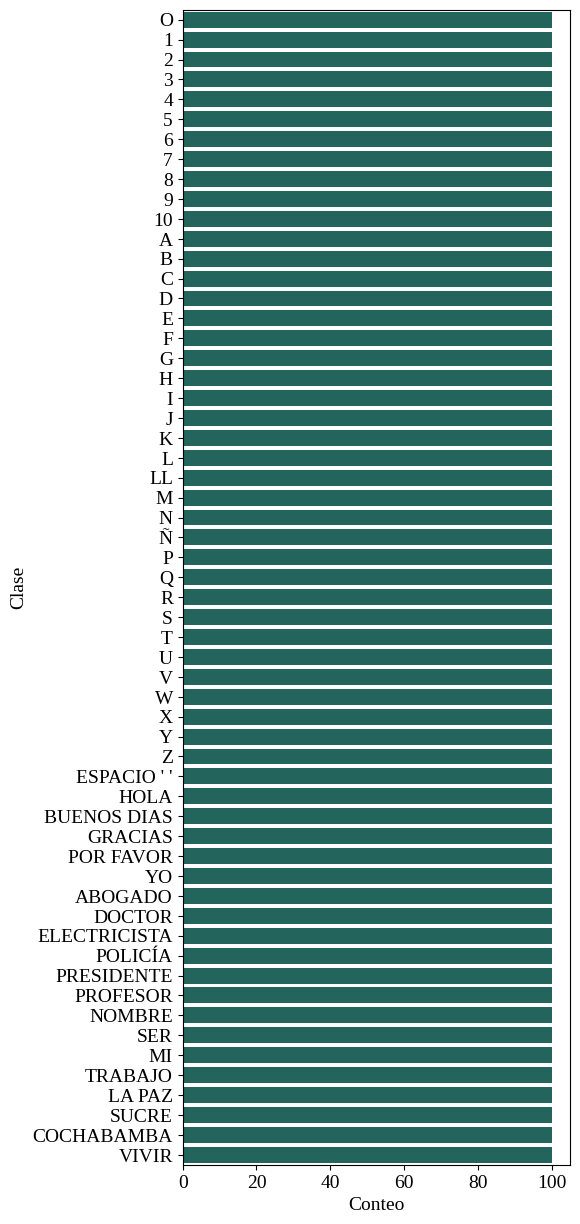

In [ ]:
fig, ax = plt.subplots(figsize=(5,15))
(
    pd.DataFrame()
    .assign(Clase=conteo_clases.index.map(signos),
            Conteo=conteo_clases.values
            )
    .pipe(lambda df:
          sns.barplot(data=df,
                      y='Clase',
                      x='Conteo',
                      orient='h',
                      palette=['#186F65'])
          )
)
plt.savefig('Conteo_de_clases.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())
plt.show()

In [ ]:
print('Clases:',pd.Series(labels_lsb).nunique())

Clases: 58


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(datos_features, labels_lsb, test_size=0.1, random_state=42, stratify=labels_lsb)

In [ ]:
#X_train.shape, y_train.shape

In [ ]:
#X_test.shape, y_test.shape

# PalabrasDataset

In [ ]:
class PalabrasDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float), torch.tensor(self.y[idx], dtype=torch.long)

In [ ]:
#train_dataset = PalabrasDataset(X_train, y_train)

In [ ]:
#train_dataset[2]

# PalabrasDataModule

In [ ]:
#Para Cross Validation
# class PalabrasDataModuleCV(pl.LightningDataModule):

#     def __init__(self, train_ds, val_ds, batch_size: int = 32):
#         super().__init__()
#         self.train_ds = train_ds
#         self.val_ds = val_ds
#         self.batch_size = batch_size


#     def setup(self, stage=None):
#         print("Tamaño de train:", len(self.train_ds))
#         print("Tamaño de test:", len(self.val_ds))


#     def train_dataloader(self):
#         return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

#     def val_dataloader(self):
#         return DataLoader(self.val_ds, batch_size=self.batch_size)

In [ ]:
class PalabrasDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 32, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):

        # División de los datos
        X_train, X_test, y_train, y_test = train_test_split(datos_features, labels_lsb, test_size=0.20, random_state=42, stratify=labels_lsb)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)
        print("Tamaño de X_train:", len(X_train))
        print("Tamaño de y_train:", len(y_train))
        print("Tamaño de X_test:", len(X_test))
        print("Tamaño de y_test:", len(y_test))

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

Revision de las dimensiones de conjuntos de datos

In [ ]:
pal_dm = PalabrasDataModule(Dataset = PalabrasDataset)
# revision
pal_dm.setup()
secuencias_prueba, labels_prueba = next(iter(pal_dm.train_dataloader()))
print('batch size:',secuencias_prueba.shape, labels_prueba.shape)

Tamaño de X_train: 4640
Tamaño de y_train: 4640
Tamaño de X_test: 1160
Tamaño de y_test: 1160
batch size: torch.Size([32, 30, 138]) torch.Size([32])


# Clase base para el entrenamiento

In [ ]:
class ModelTrain(pl.LightningModule):

    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('train_loss', loss)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        # return optimizer

        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #                      optimizer, patience=2, factor=0.1,
        #                      threshold=0.00001,
        #                      mode='min', verbose=True)
        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #         "interval": "epoch",
        #         'monitor': 'val_loss',
        #     }
        # }

# Modelo Self-Attention

In [ ]:
class ScaledDotSelfAttention(torch.nn.Module):

    def __init__(self, n_embd):
        super().__init__()

        # proyecciones key, query, value
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F = x.size()  # Batch Size, Longitud de la secuencia, cantidad de features en cada vector, 32x30x138

        # calcula query, key, values
        k = self.key(x) # (B, L, F)
        q = self.query(x) # (B, L, F)
        v = self.value(x) # (B, L, F)

        # valores de atención dim: (B, L, F) x (B, F, L) -> (B, L, L)
        att = (q @ k.transpose(1, 2)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # dim resultante: (B, L, L) x (B, L, F) -> (B, L, F)

        return y

class ModelSelfAttn(ModelTrain):

    def __init__(self, n_embd=138, seq_len=30): # n_embeding = 138 por la longitud de nuestros vectores de entrada.
        super().__init__()

        self.attn = ScaledDotSelfAttention(n_embd)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 58) # 138x30 a 58 clases
        # self.fc = torch.nn.Sequential(
        #     torch.nn.Linear(n_embd*seq_len, 4*n_embd),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(4*n_embd, n_embd),
        # )

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1))) # aplanado y luego a la fully conected
        #print(y.shape)
        return y

## Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# inicio
datos_cv = stratified_kfold.split(datos_features, labels_lsb)

In [ ]:
accuracy_list = []
f1_list = []
precision_list = []
fold=0

### Performance Cross validation modelo

In [ ]:
# Iterando a través de los pliegues (folds)
# train_idx, val_idx = next(datos_cv)

# train_data = datos_features[train_idx]
# train_labels = labels_lsb[train_idx]
# val_data = datos_features[val_idx]
# val_labels = labels_lsb[val_idx]

# fold += 1
# print(f" -------- Fold {fold} ------------")

In [ ]:
# Logger
logger_csv = CSVLogger('logs', name="modelo_self_att")
#logger_tb = TensorBoardLogger('logs', name="lightning_logs_tb")

# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

# checkpoint = ModelCheckpoint(
#         dirpath=f'modelos/self_attention/fold_{fold}',
#         filename='modelo_selfattn_{val_acc:.4f}',
#         save_top_k=1,
#         monitor='val_acc',
#         mode='max'
#     )

In [ ]:
# datasets
train_ds = PalabrasDataset(train_data, train_labels)
val_ds = PalabrasDataset(val_data, val_labels)
# Actualiza el conjunto de datos en el DataModule
pal_dm = PalabrasDataModuleCV(train_ds=train_ds, val_ds=val_ds)

NameError: ignored

In [ ]:
# Inicializa el modelo
model = ModelSelfAttn()

trainer = pl.Trainer(
                        max_epochs=20,
                        logger=logger_csv,
                        callbacks=[early_stop_callback],
                        log_every_n_steps=len(pal_dm.train_dataloader())
                        )

trainer.fit(model, pal_dm)

In [ ]:
cm, lb_real, lb_pred = cm_predicciones_modelo(model, pal_dm)
accuracy, f1, precision = evaluar_metricas_modelo(lb_real, lb_pred)

accuracy_list.append(accuracy)
f1_list.append(f1)
precision_list.append(precision)

In [ ]:
df_resultados_folds = pd.DataFrame({'accuracy': accuracy_list,
                              'f1_score': f1_list,
                              'precision': precision_list})
df_resultados_folds

## Entrenamiento del modelo

In [ ]:
# Logger
logger_csv = CSVLogger('logs', name="modelo_self_att")
#logger_tb = TensorBoardLogger('logs', name="lightning_logs_tb")

# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

checkpoint = ModelCheckpoint(
        dirpath='modelos/self_attention/',
        filename='modelo_selfattn_v12_{val_acc:.4f}',
        save_top_k=1,
        monitor='val_acc',
        mode='max'
    )

In [ ]:
# Entrenamiento modelo self attention
model_sa = ModelSelfAttn()

trainer = pl.Trainer(
    max_epochs=20,
    logger=logger_csv,
    callbacks=[early_stop_callback, checkpoint],
    log_every_n_steps=len(pal_dm.train_dataloader())
)

trainer.fit(model_sa, pal_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/modelos/self_attention exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type                   | Params
------------------------------------------------
0 | attn | ScaledDotSelfAttention | 57.5 K
1 | actn | ReLU                   | 0     
2 | fc   | Linear                 | 240 K 
------------------------------------------------
297 K     Trainable params
0         Non-trainable params
297 K     Total params
1.191     Total estimat

Tamaño de X_train: 4640
Tamaño de y_train: 4640
Tamaño de X_test: 1160
Tamaño de y_test: 1160


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


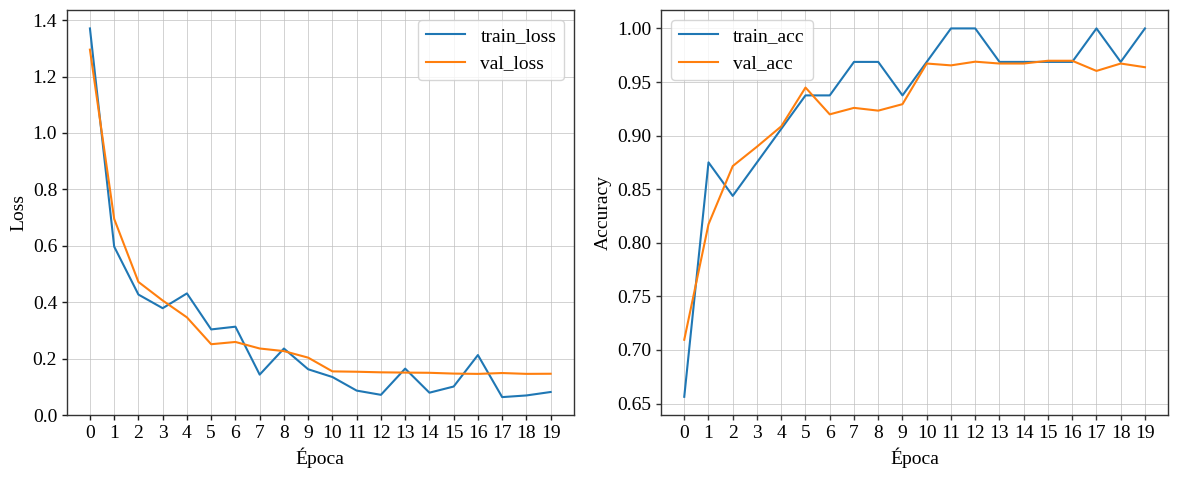

In [ ]:
df = pd.read_csv('/content/logs/modelo_self_att/version_12/metrics.csv')
plot_logs(df,'Entrenamiento_mejor_modelo_self_attention')

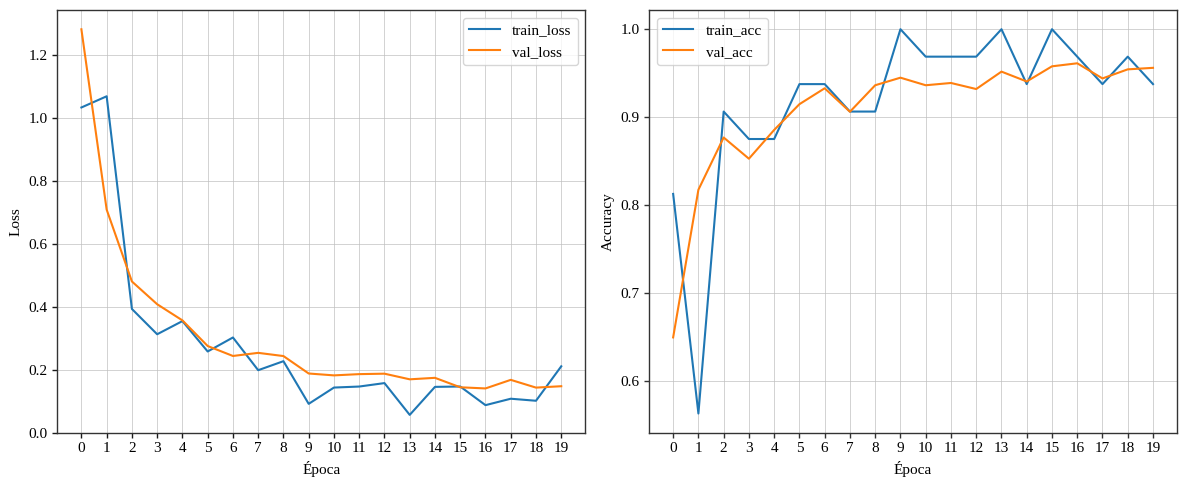

In [ ]:
df = pd.read_csv('/content/logs/modelo_self_att/version_3/metrics.csv')
plot_logs(df, 'entrenamiento_self_att_1.png')

In [ ]:
# df = pd.read_csv('logs/modelo_self_att/version_0/metrics.csv')
# plot_logs(df) #, 'entrenamiento_self_att_1.png')

In [ ]:
#sns.reset_orig()

In [ ]:
# df = pd.read_csv('logs/modelo_self_att/version_0/metrics.csv')
# plot_logs(df)

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir /content/salidas/logs/lightning_logs_tb

### Visualización cross validation

In [ ]:
df_resultados_folds

accuracy  f1_score  precision
0  0.945690  0.945669   0.954376
1  0.943966  0.941634   0.957293
2  0.958621  0.956912   0.965348
3  0.939655  0.938467   0.950328
4  0.967241  0.967635   0.975433

In [ ]:
import pandas as pd
df = pd.read_csv('/content/resultados_5CV_Self_Atten.csv')

In [ ]:
df.pivot(columns='Metrica', values='Valor').describe()

Metrica  accuracy  f1_score  precision
count    5.000000  5.000000   5.000000
mean     0.951034  0.950063   0.960556
std      0.011492  0.012047   0.009972
min      0.939655  0.938467   0.950328
25%      0.943966  0.941634   0.954376
50%      0.945690  0.945669   0.957293
75%      0.958621  0.956912   0.965348
max      0.967241  0.967635   0.975433

In [ ]:
df_resultados_folds.describe().iloc['mean','std']

In [ ]:
df_resultados_modelos = pd.melt(df_resultados_folds, var_name='Metrica', value_name='Valor')

In [ ]:
df_resultados_modelos.to_csv('resultados_5CV_Self_Attention.csv', index=False)

In [ ]:
df_resultados_folds_mha_8heads.to_csv('resultados_5CV_MHA_8heads.csv', index=False)

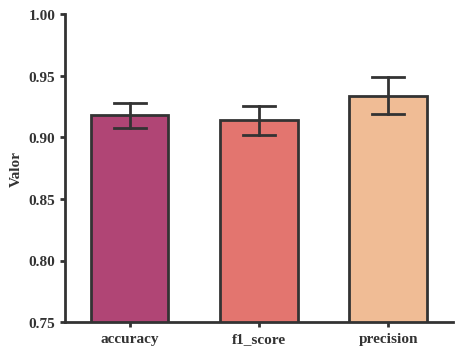

In [ ]:
plt.figure(figsize = (5,4))

ax = sns.barplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', width=0.6,
                 errorbar='sd',capsize=0.25,
                 edgecolor='0.2', lw=2.0,
                 errwidth=2.0,
                 palette=['#C23373', '#F6635C', '#FFBA86'], errcolor='0.2')

#kwargs ={'edgecolor': '0.2', 'linewidth': 2.0, 'fc':'none'}
#ax = sns.swarmplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', marker='o', s=3, **kwargs)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.0)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xticks(size=11, ha='center', weight='bold', color='0.2')
plt.yticks(size=11, weight='bold', color='0.2')

ax.tick_params(width=2.0, color='0.2')

plt.xlabel('')
plt.ylabel('Valor',size=11, weight='bold', color='0.2')
#plt.ylim(top=1.0)
plt.ylim(0.75, 1.0)

plt.savefig('bar_accurcys_self.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())

## Carga del mejor modelo

In [ ]:
# Mejor modelo Self-Attention carga y guardado
model_self = ModelSelfAttn.load_from_checkpoint(checkpoint_path="modelos/self_attention/modelo_selfattn_v1_val_acc=0.96606.ckpt")
model_self = model_self.to('cpu')
torch.save(model_self, 'modelo_self.pt')

In [ ]:
# Carga del modelo completo, incluyendo la arquitectura y los pesos
modelo_self = torch.load('modelo_self.pt')

# Cambia del modelo a modo de evaluación (si es necesario)
modelo_self.eval()

In [ ]:
# Mejor modelo transformer carga y guardado
model_te = ModelTransfomerEncoder.load_from_checkpoint(checkpoint_path="/content/modelos/transformer_encoder/modelo_transformeren_v8_val_acc=0.97759.ckpt")
model_te = model_te.to('cpu')
torch.save(model_te, 'modelo_transformer_enc.pt')

In [ ]:
# Carga del modelo completo, incluyendo la arquitectura y los pesos
modelo_tranfenco = torch.load('modelo_transformer_enc.pt')

# Cambia del modelo a modo de evaluación
modelo_tranfenco.eval()

ModelTransfomerEncoder(
  (inp_emb): Linear(in_features=138, out_features=138, bias=True)
  (tranformer): Sequential(
    (0): TransformerEncoderBlock(
      (ln1): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (key): Linear(in_features=138, out_features=552, bias=True)
        (query): Linear(in_features=138, out_features=552, bias=True)
        (value): Linear(in_features=138, out_features=552, bias=True)
        (proj): Linear(in_features=552, out_features=138, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=138, out_features=552, bias=True)
        (1): ReLU()
        (2): Linear(in_features=552, out_features=138, bias=True)
      )
    )
    (1): TransformerEncoderBlock(
      (ln1): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
  

## Evaluación

In [ ]:
cm_sa, lb_real_sa, lb_pred_sa = cm_predicciones_modelo(model_sa, pal_dm)
cm_sa

Tamaño conjunto de validación - real: (1160,)
Tamaño conjunto de validación - predicho: (1160,)


array([[20,  0,  0, ...,  0,  0,  0],
       [ 0, 20,  0, ...,  0,  0,  0],
       [ 0,  0, 20, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 20,  0,  0],
       [ 0,  0,  0, ...,  0, 19,  0],
       [ 0,  0,  0, ...,  0,  0, 20]])

In [ ]:
def graficar_matrix_confusion(cm, nombre_modelo:str, nombre_figura:str=''):
    """
    Gráfico de la matriz de confusión completa con todas las clases
    """
    plt.figure(figsize=(18,18))
    ax = sns.heatmap(cm, annot=True, cbar=False) #cmap='viridis')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Matriz de confusión - {nombre_modelo}')
    if nombre_figura:
        plt.savefig(f'{nombre_figura}.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())
    plt.show()

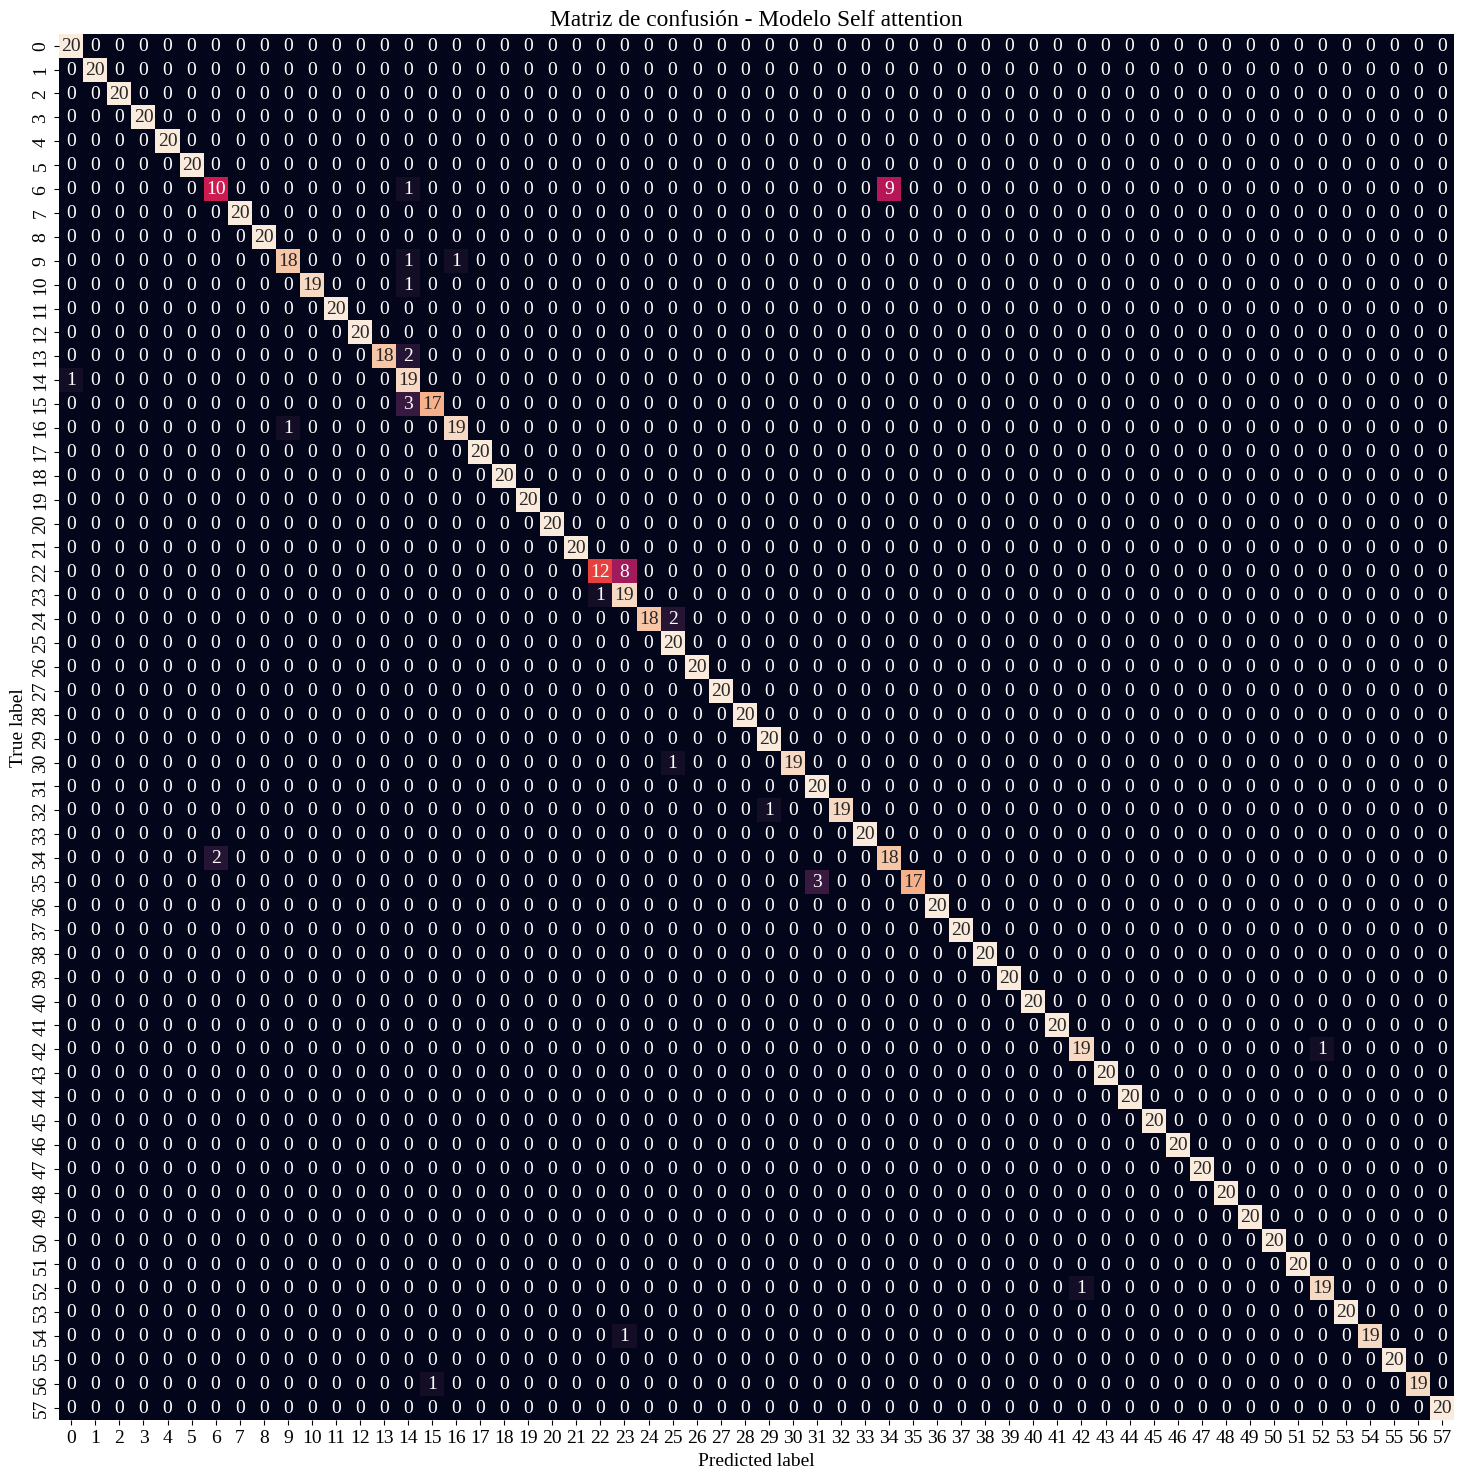

In [ ]:
graficar_matrix_confusion(cm_sa, 'Modelo Self attention', 'Matriz_de_confusion_modelo_selfAttention')

In [ ]:
os.mkdir('graficos')
# Matriz de confusion por partes
def graficar_matrizConfporpartes(cm, labels_real, nombre_modelo:str=None):
    if nombre_modelo is not None:
        carpeta= f'graficos/{nombre_modelo}/'
        if not os.path.exists(carpeta):
            os.mkdir(carpeta)
            print(f"La carpeta '{carpeta}' ha sido creada.")
        else:
            print(f"La carpeta '{carpeta}' ya existe, crear otra.")
            return None

    labels = np.unique(labels_real)

    plt.figure(figsize=(16, 16))
    # Dividir en bloques y visualizar cada bloque
    block_size = 10
    for i in range(0, len(labels), block_size):
        end_idx = min(i + block_size, len(labels))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm[i:end_idx, i:end_idx], display_labels=labels[i:end_idx])
        disp.plot(cmap='rocket')
        plt.title(f'Matriz de Confusión (Clases {i} a {end_idx-1})')
        if nombre_modelo is not None:
            plt.savefig(f'graficos/{nombre_modelo}/mconf_{i}_a_{end_idx-1}.png', bbox_inches='tight', dpi=250)
        plt.show()

La carpeta 'graficos/Modelo_self_attention/' ha sido creada.


<Figure size 1600x1600 with 0 Axes>

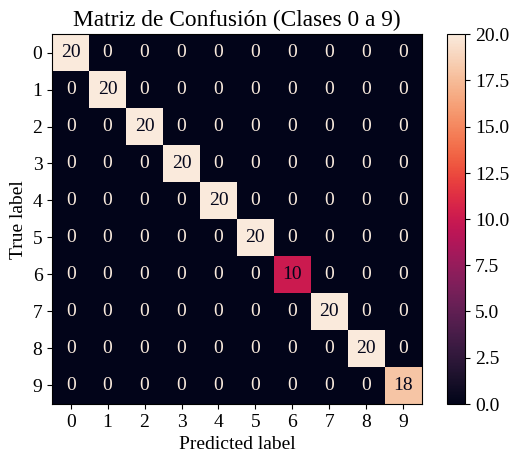

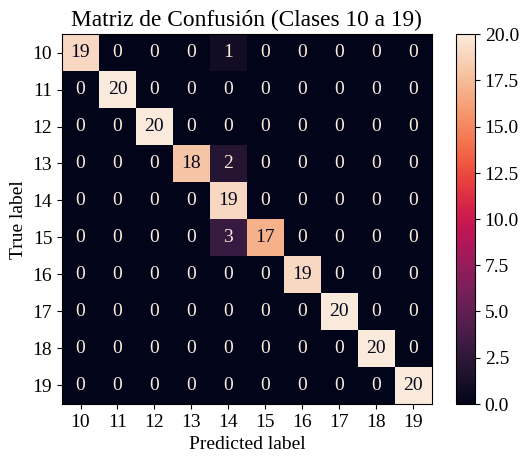

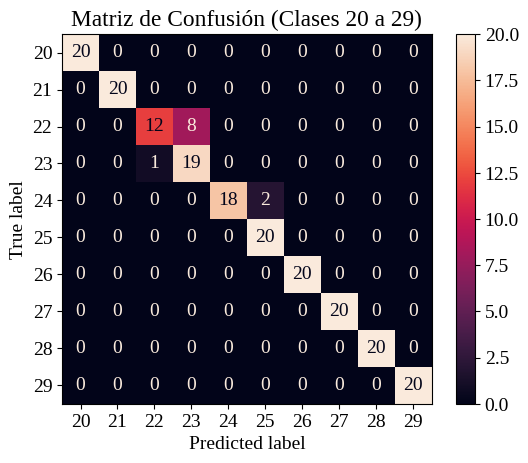

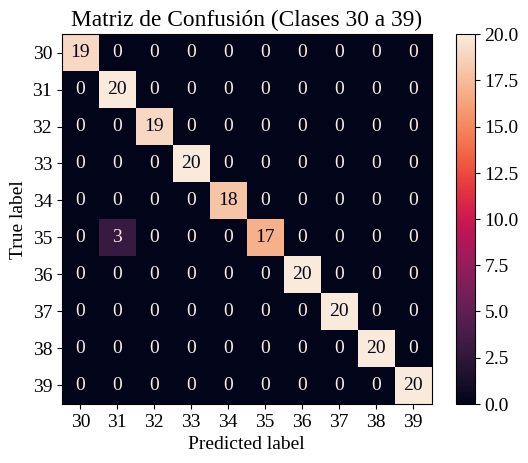

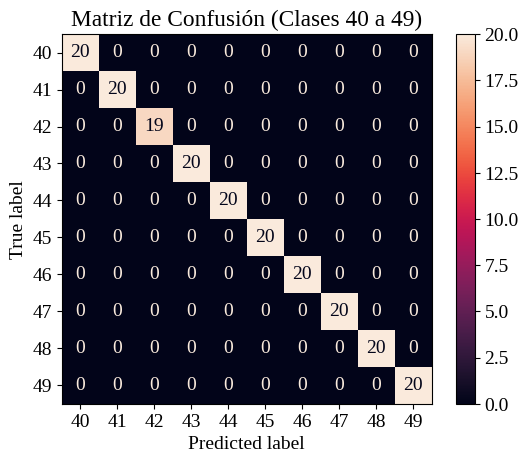

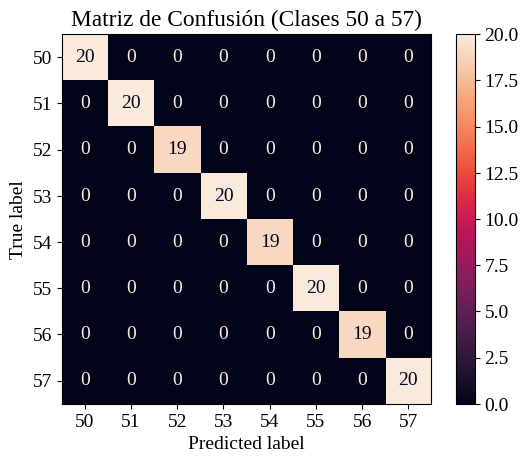

In [ ]:
graficar_matrizConfporpartes(cm_sa, lb_real_sa, 'Modelo_self_attention')

In [ ]:
# Guardar imagenes
import shutil
shutil.make_archive('matrices_confusion_Self_Attention', 'zip', '/content/graficos/Modelo_self_attention')

'/content/matrices_confusion_Self_Attention.zip'

In [ ]:
evaluar_metricas_modelo(lb_real_sa, lb_pred_sa, 'Modelo self attention')

Metricas de evaluación: Modelo self attention

Val - Accuracy: 0.964
Val - F1 Score: 0.964
Val - Precisión: 0.969


(0.9637931034482758, 0.9635061466469174, 0.9688113320757524)

In [ ]:
def reporte(labels_real,labels_preds,nombre_modelo):
    # Metricas por clase y en general
    report = classification_report(labels_real, labels_preds, zero_division=0.0) # prevenir division por cero
    print(f"Informe de clasificación del conjunto de validación: {nombre_modelo} \n", report)

In [ ]:
reporte(lb_real_sa, lb_pred_sa, 'Modelo self Attention')

Informe de clasificación del conjunto de validación: Modelo self Attention 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        20
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00        20
           6       0.83      0.50      0.62        20
           7       1.00      1.00      1.00        20
           8       1.00      1.00      1.00        20
           9       0.95      0.90      0.92        20
          10       1.00      0.95      0.97        20
          11       1.00      1.00      1.00        20
          12       1.00      1.00      1.00        20
          13       1.00      0.90      0.95        20
          14       0.70      0.95      0.81        20
          15       0.94      0.85      0.89        20
    



## Pruebas del modelo

In [ ]:
#!zip -r modelo_palabras_2_acc_0_98.zip /content/lightning_logs/version_2

In [ ]:
# # Carga el modelo completo, incluyendo la arquitectura y los pesos
# modelo_cargado = torch.load('modelo_self_attention.pt')

# # Cambia el modelo a modo de evaluación (si es necesario)
# modelo_cargado.eval()

In [ ]:
ejem = 3
secuencia_prueba = pal_dm.val_ds[ejem][0].unsqueeze(0)
label_prueba = pal_dm.val_ds[ejem][1]
print(secuencia_prueba.shape)
print(label_prueba)

In [ ]:
model.eval()
prediccion = model(secuencia_prueba)
prediccion

In [ ]:
prediccion_letra = np.argmax(prediccion.detach().numpy())
print(prediccion_letra)

In [ ]:
exp_vector = np.exp(prediccion.detach().numpy())
probabilidades = exp_vector / np.sum(exp_vector, axis=1, keepdims=True)


In [ ]:
probabilidades[0, prediccion_letra].round(3)

## Guardado en ONNX

In [ ]:
import torch.onnx

In [ ]:
torch.onnx.export(
    modelo_tranfenco.cpu(),
    torch.randn(1, 30, 138),
    'model_transformer_enco_v4.onnx',
    opset_version=11,
    input_names=['input'],
    output_names=['output'],
    #dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}
)

<ipython-input-103-66a59d7a5bf4>:24: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))
<ipython-input-103-66a59d7a5bf4>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))


In [ ]:
torch.onnx.export(
    modelo_self.cpu(),
    torch.randn(1, 30, 138),
    'model_selfattn_v2.onnx',
    opset_version=11,
    input_names=['input'],
    output_names=['output'],
    #dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}
)

In [ ]:
# import onnx

# onnx_model = onnx.load('model_self_attention_v1.onnx')
# onnx.checker.check_model(onnx_model)

### Onnxruntime

In [ ]:
!pip install onnxruntime

In [ ]:
ejem = 3
secuencia_prueba = pal_dm.val_ds[ejem][0].unsqueeze(0)
label_prueba = pal_dm.val_ds[ejem][1]
print(secuencia_prueba.shape)
print(label_prueba)

In [ ]:
sec_numpy = secuencia_prueba.numpy().astype(np.float32)

In [ ]:
import onnxruntime as ort
# Path al modelo ONNX
path_modelo_onnx = '/content/model_transformer_enco_v1.onnx'
# Carga del modelo ONNX
ort_session = ort.InferenceSession(path_modelo_onnx)

In [ ]:
# datos de entrada prueba
ort_inputs = {'input': sec_numpy}  # alternativa nombre: ort_session.get_inputs()[0].name
# Inferencia del Modelo
ort_outputs = ort_session.run(None, ort_inputs)

In [ ]:
ort_outputs[0].shape

In [ ]:
print(ort_outputs[0])

In [ ]:
np.argmax(ort_outputs[0])

In [ ]:
exp_vector = np.exp(ort_outputs[0])
probabilidades = exp_vector / np.sum(exp_vector, axis=1, keepdims=True)

In [ ]:
probabilidades[0, np.argmax(ort_outputs[0])].round(3)

In [ ]:
np.argmax(probabilidades)

# Modelo Multi-Head Attention

In [ ]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.as_tensor(k.size(-1), dtype=torch.float32)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # se une todas las salidas cabezas lado a lado

        return self.proj(y)

class ModelMhAtt(ModelTrain):

    def __init__(self, n_embd=138, seq_len=30, n_heads=4):
        super().__init__()

        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 58) # 58 clases

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

## Cross validation

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# inicio
datos_cv = stratified_kfold.split(datos_features, labels_lsb)

In [ ]:
accuracy_list = []
f1_list = []
precision_list = []
fold=0

### Performance Cross validation modelo

In [ ]:
# Iterando a través de los pliegues (folds)
train_idx, val_idx = next(datos_cv)

train_data = datos_features[train_idx]
train_labels = labels_lsb[train_idx]
val_data = datos_features[val_idx]
val_labels = labels_lsb[val_idx]

fold += 1
print(f" -------- Fold {fold} ------------")

 -------- Fold 5 ------------


In [ ]:
# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

In [ ]:
# datasets
train_ds = PalabrasDataset(train_data, train_labels)
val_ds = PalabrasDataset(val_data, val_labels)
# Actualiza el conjunto de datos en el DataModule
pal_dm = PalabrasDataModuleCV(train_ds=train_ds, val_ds=val_ds)

In [ ]:
model_mha = ModelMhAtt(n_heads=8)
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    #logger=logger_csv_mha,
    callbacks=[early_stop_callback],
    #log_every_n_steps=len(pal_dm.train_dataloader())
)
trainer.fit(model_mha, pal_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type               | Params
--------------------------------------------
0 | attn | MultiHeadAttention | 612 K 
1 | actn | ReLU               | 0     
2 | fc   | Linear             | 240 K 
--------------------------------------------
853 K     Trainable params
0         Non-trainable params
853 K     Total params
3.412     Total estimated model params size (MB)


Tamaño de train: 4640
Tamaño de test: 1160


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
cm, lb_real, lb_pred = cm_predicciones_modelo(model_mha, pal_dm)
accuracy, f1, precision = evaluar_metricas_modelo(lb_real, lb_pred)

accuracy_list.append(accuracy)
f1_list.append(f1)
precision_list.append(precision)

Tamaño conjunto de validación - real: (1160,)
Tamaño conjunto de validación - predicho: (1160,)
Metricas de evaluación: 

Val - Accuracy: 0.924
Val - F1 Score: 0.926
Val - Precisión: 0.949


In [ ]:
df_resultados_folds_mha = pd.DataFrame({'accuracy': accuracy_list,
                              'f1_score': f1_list,
                              'precision': precision_list})
df_resultados_folds_mha

accuracy  f1_score  precision
0  0.932759  0.927536   0.948384
1  0.912069  0.905709   0.932631
2  0.912931  0.907916   0.915170
3  0.907759  0.903021   0.925334
4  0.924138  0.926301   0.948800

### Resultados csv

In [ ]:
df_resultados_folds_mha_2heads = df_resultados_folds_mha.copy()

In [ ]:
df_resultados_folds_mha_2heads['Cantidad_Cabezas'] = '2 heads'
df_resultados_folds_mha_2heads

accuracy  f1_score  precision Cantidad_Cabezas
0  0.880172  0.873209   0.888856          2 heads
1  0.907759  0.903831   0.920687          2 heads
2  0.918103  0.912237   0.934387          2 heads
3  0.925000  0.925969   0.940278          2 heads
4  0.926724  0.921801   0.923815          2 heads

In [ ]:
df_resultados_folds_mha_4heads = df_resultados_folds_mha.copy()

In [ ]:
df_resultados_folds_mha_4heads['Cantidad_Cabezas'] = '4 heads'
df_resultados_folds_mha_4heads

In [ ]:
df_resultados_folds_mha_8heads = df_resultados_folds_mha.copy()

In [ ]:
df_resultados_folds_mha_8heads['Cantidad_Cabezas'] = '8 heads'
df_resultados_folds_mha_8heads

accuracy  f1_score  precision Cantidad_Cabezas
0  0.932759  0.927536   0.948384          8 heads
1  0.912069  0.905709   0.932631          8 heads
2  0.912931  0.907916   0.915170          8 heads
3  0.907759  0.903021   0.925334          8 heads
4  0.924138  0.926301   0.948800          8 heads

In [ ]:
df_resultados_folds_mha_4heads

accuracy  f1_score  precision Cantidad_Cabezas
0  0.918966  0.911236   0.918764          4 heads
1  0.937069  0.939118   0.947869          4 heads
2  0.944828  0.942902   0.952104          4 heads
3  0.937069  0.932463   0.935095          4 heads
4  0.953448  0.953856   0.958517          4 heads

In [ ]:
df_resultados_MHA_experimentos = pd.concat([df_resultados_folds_mha_2heads,
                                            df_resultados_folds_mha_4heads,
                                            df_resultados_folds_mha_8heads
                                            ])

### Visualización Cross Validation

In [ ]:
df_resultados_MHA_experimentos

accuracy  f1_score  precision Cantidad_Cabezas
0  0.880172  0.873209   0.888856          2 heads
1  0.907759  0.903831   0.920687          2 heads
2  0.918103  0.912237   0.934387          2 heads
3  0.925000  0.925969   0.940278          2 heads
4  0.926724  0.921801   0.923815          2 heads
0  0.918966  0.911236   0.918764          4 heads
1  0.937069  0.939118   0.947869          4 heads
2  0.944828  0.942902   0.952104          4 heads
3  0.937069  0.932463   0.935095          4 heads
4  0.953448  0.953856   0.958517          4 heads
0  0.932759  0.927536   0.948384          8 heads
1  0.912069  0.905709   0.932631          8 heads
2  0.912931  0.907916   0.915170          8 heads
3  0.907759  0.903021   0.925334          8 heads
4  0.924138  0.926301   0.948800          8 heads

In [ ]:
df_resultados_MHA_experimentos.query('Cantidad_Cabezas=="2 heads"').describe()

accuracy  f1_score  precision
count  5.000000  5.000000   5.000000
mean   0.911552  0.907409   0.921605
std    0.019059  0.020960   0.019939
min    0.880172  0.873209   0.888856
25%    0.907759  0.903831   0.920687
50%    0.918103  0.912237   0.923815
75%    0.925000  0.921801   0.934387
max    0.926724  0.925969   0.940278

In [ ]:
df_resultados_MHA_experimentos.query('Cantidad_Cabezas=="4 heads"').describe()

accuracy  f1_score  precision
count  5.000000  5.000000   5.000000
mean   0.938276  0.935915   0.942470
std    0.012737  0.015826   0.015779
min    0.918966  0.911236   0.918764
25%    0.937069  0.932463   0.935095
50%    0.937069  0.939118   0.947869
75%    0.944828  0.942902   0.952104
max    0.953448  0.953856   0.958517

In [ ]:
df_resultados_MHA_experimentos.query('Cantidad_Cabezas=="8 heads"').describe()

accuracy  f1_score  precision
count  5.000000  5.000000   5.000000
mean   0.917931  0.914097   0.934064
std    0.010262  0.011841   0.014641
min    0.907759  0.903021   0.915170
25%    0.912069  0.905709   0.925334
50%    0.912931  0.907916   0.932631
75%    0.924138  0.926301   0.948384
max    0.932759  0.927536   0.948800

In [ ]:
df_mha_ord = pd.melt(df_resultados_MHA_experimentos, id_vars='Cantidad_Cabezas', var_name='Metrica', value_name='Valor')

In [ ]:
df_mha_ord.to_csv('resultados_5CV_MULTIHEAD.csv', index=False)

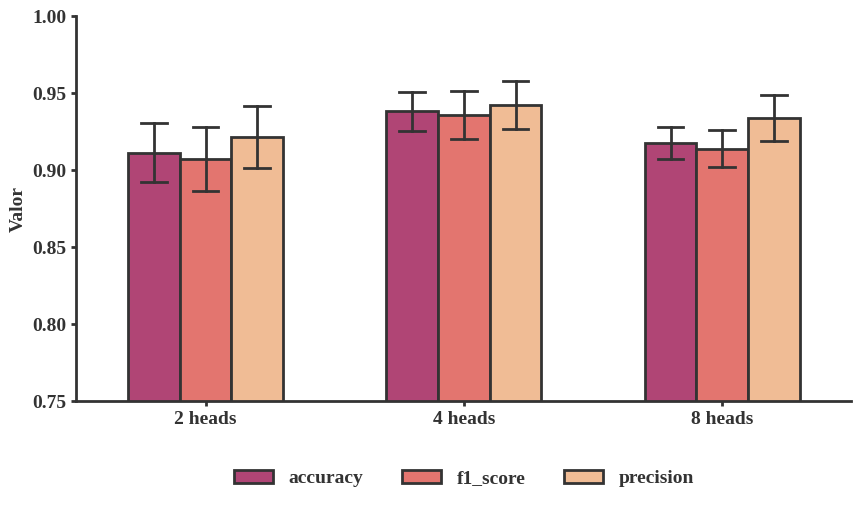

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(data=df_mha_ord, x = 'Cantidad_Cabezas', y = 'Valor', width=0.6,
                 errorbar='sd',capsize=0.1,
                 edgecolor='0.2', lw=2.0,
                 errwidth=2.0,
                 palette= ['#C23373', '#F6635C', '#FFBA86'],
                 errcolor='0.2', hue='Metrica')

#kwargs ={'edgecolor': '0.2', 'linewidth': 2.0, 'fc':'none'}
#ax = sns.swarmplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', marker='o', s=3, **kwargs)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:], labels[:], loc=10, bbox_to_anchor=(0.5, -0.20),
           ncol=3, frameon=False, fontsize=14, labelcolor='0.2',
           prop={'weight':'bold', 'size':14})



for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.0)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xticks(size=14, ha='center', weight='bold', color='0.2')
plt.yticks(size=14, weight='bold', color='0.2')

ax.tick_params(width=2.0, color='0.2')

plt.xlabel('')
plt.ylabel('Valor',size=14, weight='bold', color='0.2')
#plt.ylim(top=1.0)
plt.ylim(0.75, 1.0)

#plt.savefig('bar_accurcys_self.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())
plt.show()

## Entrenamiento modelo

In [ ]:
# logger
logger_csv_mha = CSVLogger('logs', name="modelo_mha")

# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

checkpoint = ModelCheckpoint(
    dirpath='modelos/multihead_attention',
    filename='modelo_mha_v4_{val_acc:.5f}',
    save_top_k=1,
    monitor='val_acc',
    mode='max'
)

In [ ]:
model_mha = ModelMhAtt(n_heads=4)
trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    logger=logger_csv_mha,
    callbacks=[early_stop_callback, checkpoint],
    log_every_n_steps=len(pal_dm.train_dataloader())
)

trainer.fit(model_mha, pal_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/modelos/multihead_attention exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type               | Params
--------------------------------------------
0 | attn | MultiHeadAttention | 306 K 
1 | actn | ReLU               | 0     
2 | fc   | Linear             | 240 K 
--------------------------------------------
546 K     Trainable params
0         Non-trainable params
546 K     Total params
2.187     Total estimated model params siz

Tamaño de X_train: 4640
Tamaño de y_train: 4640
Tamaño de X_test: 1160
Tamaño de y_test: 1160


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


## Evaluación

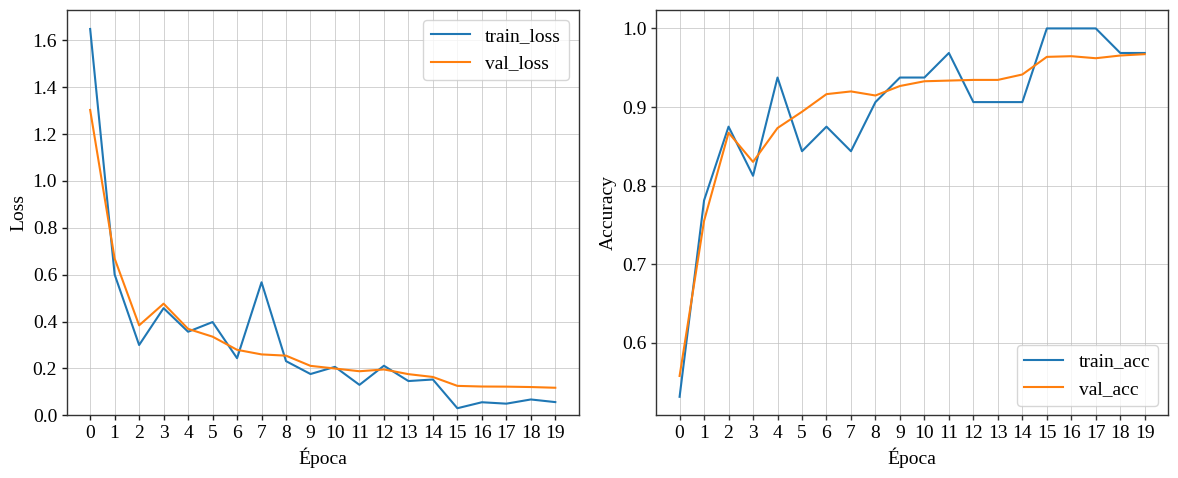

In [ ]:
df = pd.read_csv('/content/logs/modelo_mha/version_4/metrics.csv')
plot_logs(df, 'Entrenamiento_mejor_modelo_multi_attention')

In [ ]:
# model_graph_2 = draw_graph(model_mha,
#                          input_size=(32, 30,138),
#                          depth=1
#                          #save_graph=True,
#                          #filename='Modelo_MHA'
#                          )
# model_graph_2.visual_graph

In [ ]:
cm_mha, lb_real_mha, lb_pred_mha = cm_predicciones_modelo(model_mha, pal_dm)

Tamaño conjunto de validación - real: (1160,)
Tamaño conjunto de validación - predicho: (1160,)


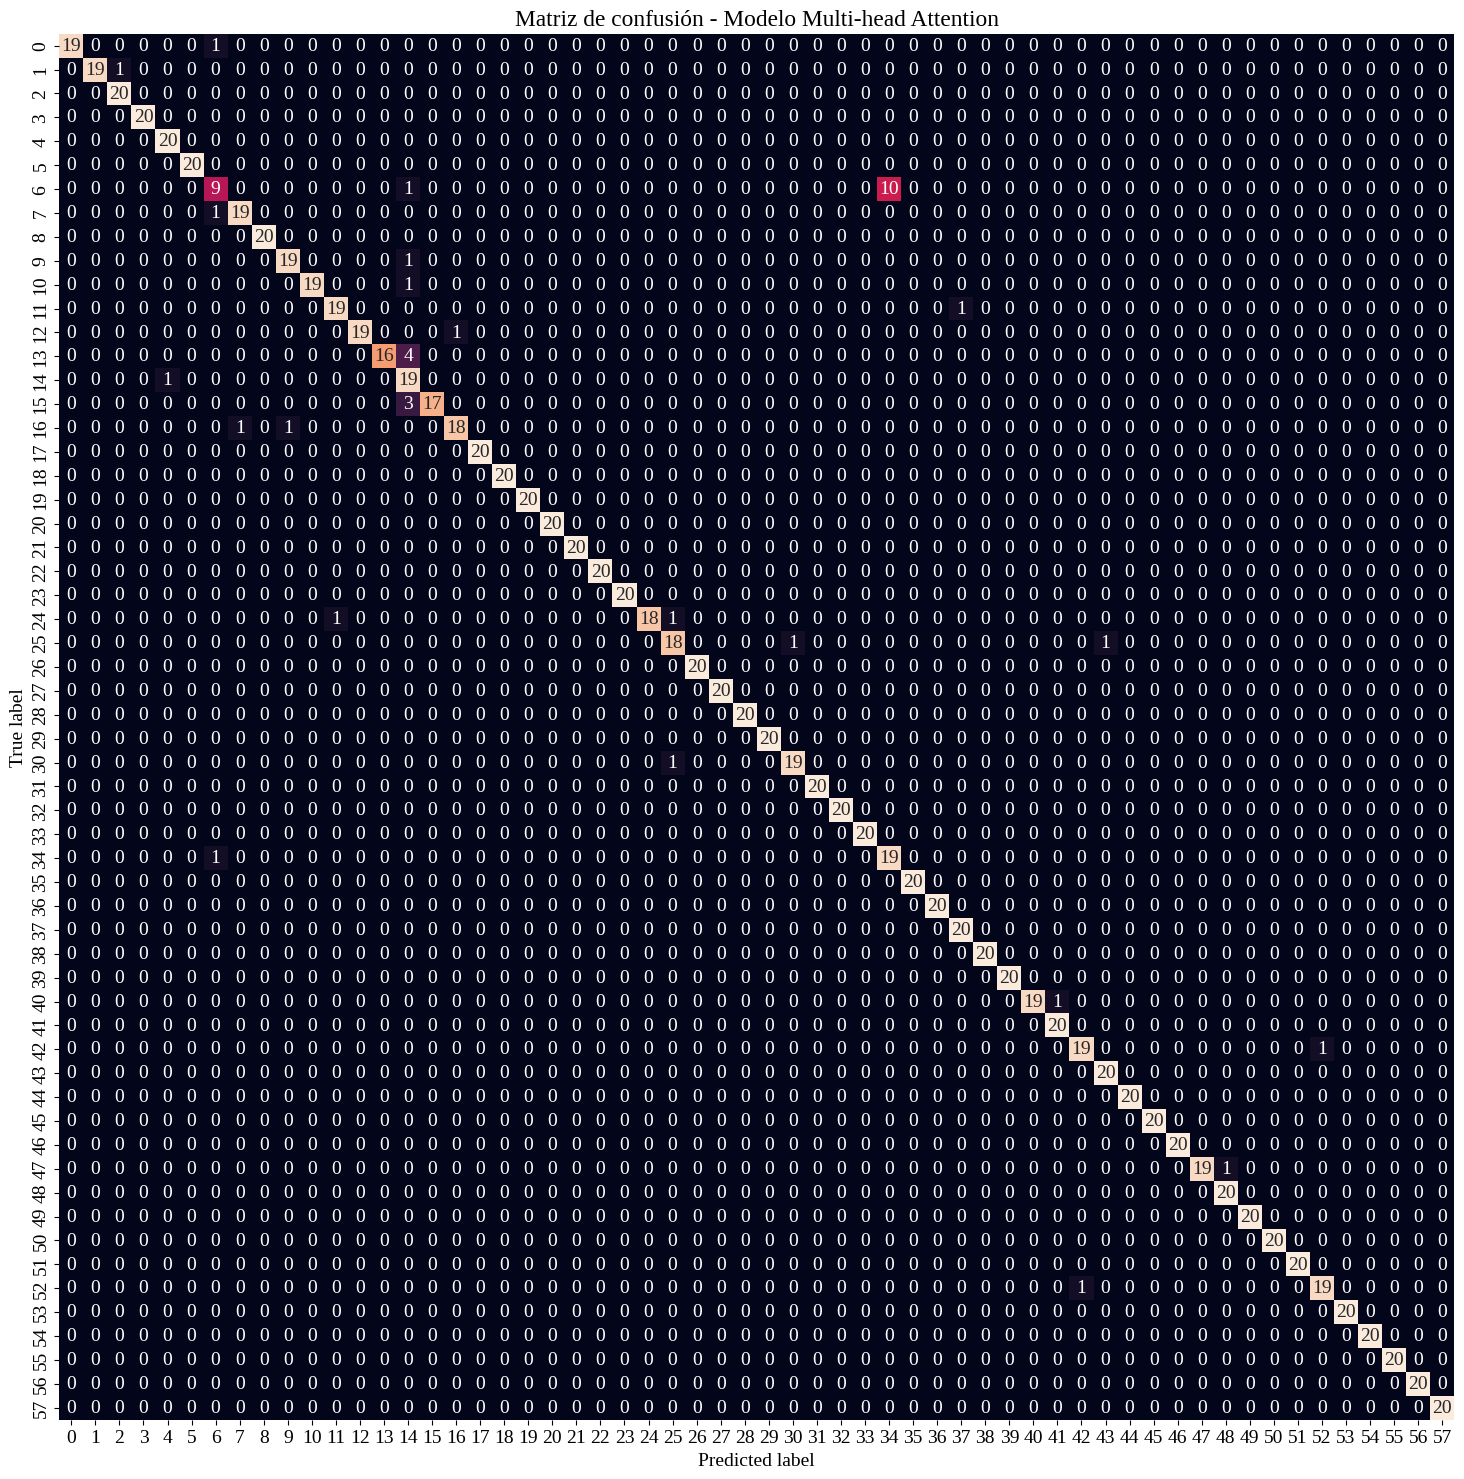

In [ ]:
graficar_matrix_confusion(cm_mha, 'Modelo Multi-head Attention', 'Matriz_confusion_Multi_head_Attention')

La carpeta 'graficos/Modelo_Multi_head_Attention/' ha sido creada.


<Figure size 1600x1600 with 0 Axes>

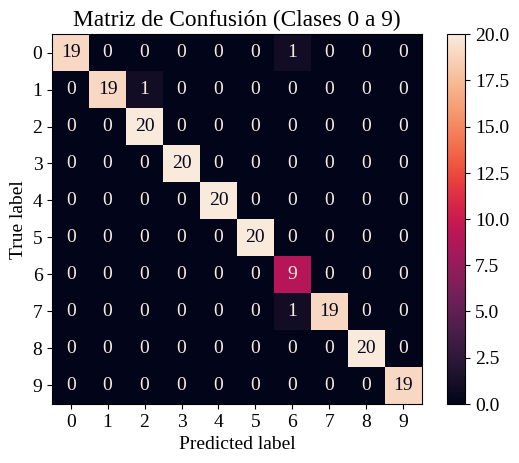

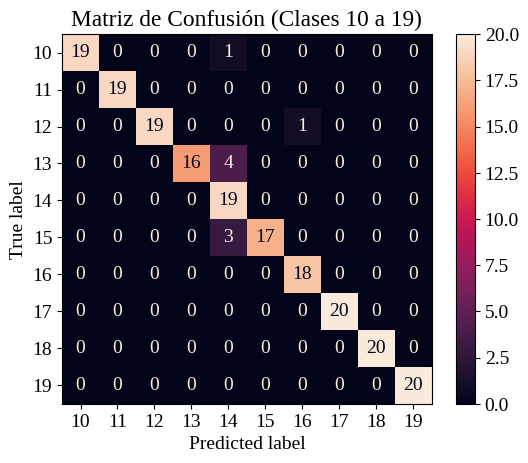

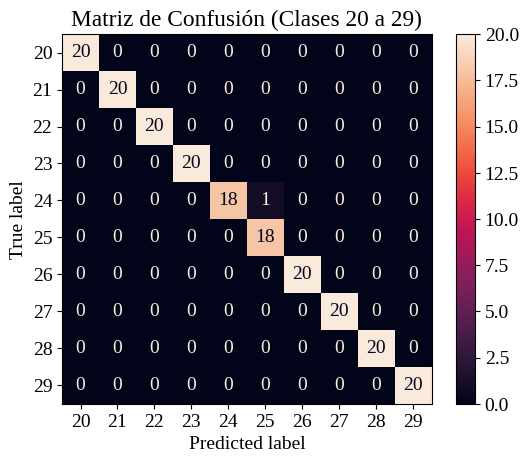

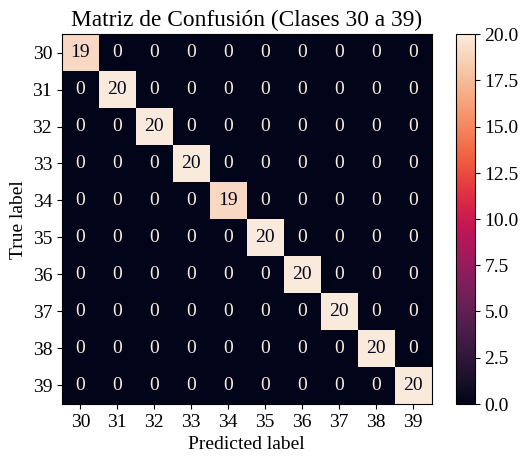

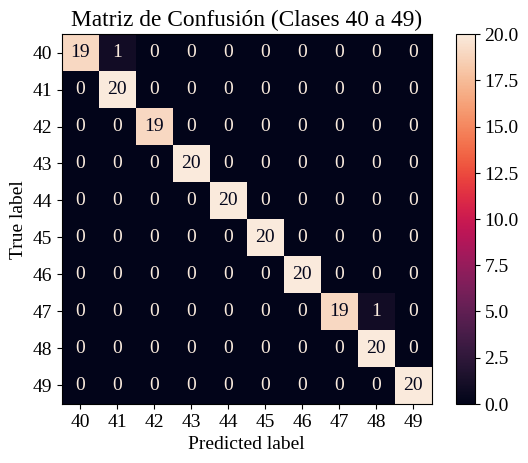

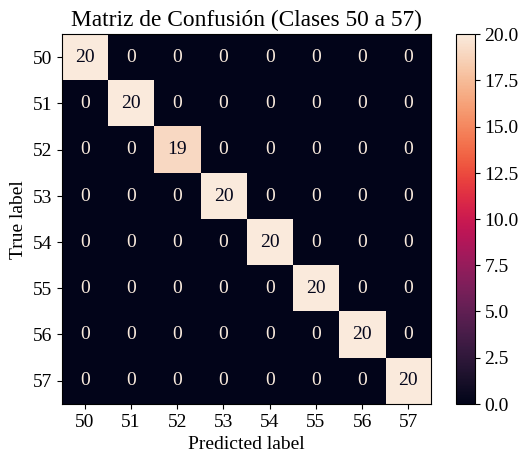

In [ ]:
graficar_matrizConfporpartes(cm_mha, lb_real_mha, 'Modelo_Multi_head_Attention')

In [ ]:
# Guardar imagenes
import shutil
shutil.make_archive('mats_confusion_Multi_head_Attention', 'zip', '/content/graficos/Modelo_Multi_head_Attention')

'/content/mats_confusion_Multi_head_Attention.zip'

In [ ]:
evaluar_metricas_modelo(lb_real_mha, lb_pred_mha, 'Modelo Multi-head Attention')

Metricas de evaluación: Modelo Multi-head Attention

Val - Accuracy: 0.967
Val - F1 Score: 0.967
Val - Precisión: 0.971


(0.9672413793103448, 0.9670963093593076, 0.9710689476366302)

## Visualizacion rendimiento promedio

In [ ]:
# import os
# # Directorio que contiene los checkpoints
# checkpoint_directory = "modelos/multihead_attention"

# modelos_mha = []

# for filename in os.listdir(checkpoint_directory):
#     if filename.endswith(".ckpt"):
#         checkpoint_path = os.path.join(checkpoint_directory, filename)
#         # Carga el modelo desde el checkpoint
#         model = ModelMhAtt.load_from_checkpoint(checkpoint_path=checkpoint_path)
#         model = model.to('cpu')

#         modelos_mha.append(model)

In [ ]:
# accuracy_list = []
# f1_list = []
# precision_list = []

# for model in modelos_mha:
#     model.eval()
#     cm, lb_real, lb_pred = cm_predicciones_modelo(model)
#     accuracy, f1, precision = evaluar_metricas_modelo(lb_real, lb_pred)
#     accuracy_list.append(accuracy)
#     f1_list.append(f1)
#     precision_list.append(precision)

# df_resultados = pd.DataFrame({'accuracy': accuracy_list,
#                               'f1_score': f1_list,
#                               'precision': precision_list})
# df_resultados

Tamaño conjunto de validación - real: (383,)
Tamaño conjunto de validación - predicho: (383,)
Metricas de evaluación: 

Val - Accuracy: 0.937
Val - F1 Score: 0.944
Val - Precisión: 0.952
Tamaño conjunto de validación - real: (383,)
Tamaño conjunto de validación - predicho: (383,)
Metricas de evaluación: 

Val - Accuracy: 0.935
Val - F1 Score: 0.937
Val - Precisión: 0.953
Tamaño conjunto de validación - real: (383,)
Tamaño conjunto de validación - predicho: (383,)
Metricas de evaluación: 

Val - Accuracy: 0.919
Val - F1 Score: 0.923
Val - Precisión: 0.935
Tamaño conjunto de validación - real: (383,)
Tamaño conjunto de validación - predicho: (383,)
Metricas de evaluación: 

Val - Accuracy: 0.935
Val - F1 Score: 0.941
Val - Precisión: 0.950
Tamaño conjunto de validación - real: (383,)
Tamaño conjunto de validación - predicho: (383,)
Metricas de evaluación: 

Val - Accuracy: 0.948
Val - F1 Score: 0.950
Val - Precisión: 0.959


accuracy  f1_score  precision
0  0.937337  0.943663   0.951982
1  0.934726  0.936927   0.952555
2  0.919060  0.922607   0.935355
3  0.934726  0.941408   0.949529
4  0.947781  0.950058   0.958969

In [ ]:
df_resultados.to_csv('resultados_entrenamientos_mha.csv', index=False)

In [ ]:
df_resultados_modelos = pd.melt(df_resultados, var_name='Metrica', value_name='Valor')

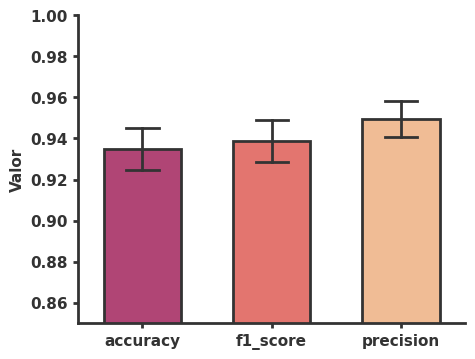

In [ ]:
plt.figure(figsize = (5,4))

ax = sns.barplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', width=0.6,
                 errorbar='sd',capsize=0.25,
                 edgecolor='0.2', lw=2.0,
                 errwidth=2.0,
                 palette=['#C23373', '#F6635C', '#FFBA86'], errcolor='0.2')

#kwargs ={'edgecolor': '0.2', 'linewidth': 2.0, 'fc':'none'}
#ax = sns.swarmplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', marker='o', s=3, **kwargs)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.0)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xticks(size=11, ha='center', weight='bold', color='0.2')
plt.yticks(size=11, weight='bold', color='0.2')

ax.tick_params(width=2.0, color='0.2')

plt.xlabel('')
plt.ylabel('Valor',size=11, weight='bold', color='0.2')
#plt.ylim(top=1.0)
plt.ylim(0.85, 1.0)

plt.savefig('bar_accurcys_self.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())

# Modelo Transformer Encoder

In [ ]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd * n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd * n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd * n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

class TransformerEncoderBlock(torch.nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_embd, 4 * n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        x = self.ln1(x + self.attn(x))
        x = self.ln2(x + self.mlp(x))
        return x

class ModelTransfomerEncoder(ModelTrain):

    def __init__(self, n_input=138, n_embd=138, seq_len=30, n_heads=8, n_layers=2):
        super().__init__()
        self.pos_emb = torch.nn.Parameter(torch.zeros(1, seq_len, n_embd))
        self.inp_emb = torch.nn.Linear(n_input, n_embd)
        self.tranformer = torch.nn.Sequential(*[TransformerEncoderBlock(n_embd, n_heads) for _ in range(n_layers)])
        self.fc = torch.nn.Linear(n_embd*seq_len, 58) # 58 clases


    def forward(self, x):
        # embedding
        e = self.inp_emb(x) + self.pos_emb
        # transformer blocks
        x = self.tranformer(e)
        # classifier
        y = self.fc(x.view(x.size(0), -1))
        return y

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        # return optimizer

        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

        # return {
        #     'optimizer': optimizer,
        #     'lr_scheduler': {
        #         'scheduler': scheduler,
        #     }
        # }

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                             optimizer, patience=2, factor=0.1,
                             threshold=0.001,
                             mode='max', verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                "interval": "epoch",
                'monitor': 'val_acc',
            }
        }


## Cross Validation

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# inicio del generador de splits
datos_cv = stratified_kfold.split(datos_features, labels_lsb)

In [ ]:
accuracy_list = []
f1_list = []
precision_list = []
fold=0

### Rendimiento Cross validation del modelo

In [ ]:
# Iterando a través de los pliegues (folds)
train_idx, val_idx = next(datos_cv)

train_data = datos_features[train_idx]
train_labels = labels_lsb[train_idx]
val_data = datos_features[val_idx]
val_labels = labels_lsb[val_idx]

fold += 1
print(f" -------- Fold {fold} ------------")

 -------- Fold 5 ------------


In [ ]:
# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

In [ ]:
# datasets
train_ds = PalabrasDataset(train_data, train_labels)
val_ds = PalabrasDataset(val_data, val_labels)
# Actualiza el conjunto de datos en el DataModule
pal_dm = PalabrasDataModuleCV(train_ds=train_ds, val_ds=val_ds)

In [ ]:
model_te = ModelTransfomerEncoder(n_heads=8, n_layers=2) # (n_heads=8, n_layers=2)

trainer = pl.Trainer(
                    max_epochs=20,
                    accelerator="auto",
                    callbacks=[early_stop_callback],
                    #log_every_n_steps=len(pal_dm.train_dataloader())
                    )
trainer.fit(model_te, pal_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | inp_emb      | Linear     | 19.2 K
1 | tranformer   | Sequential | 1.5 M 
2 | fc           | Linear     | 240 K 
  | other params | n/a        | 4.1 K 
--------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.186     Total estimated model params size (MB)


Tamaño de train: 4640
Tamaño de test: 1160


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
cm, lb_real, lb_pred = cm_predicciones_modelo(model_te, pal_dm)
accuracy, f1, precision = evaluar_metricas_modelo(lb_real, lb_pred)

accuracy_list.append(accuracy)
f1_list.append(f1)
precision_list.append(precision)

Tamaño conjunto de validación - real: (1160,)
Tamaño conjunto de validación - predicho: (1160,)
Metricas de evaluación: 

Val - Accuracy: 0.956
Val - F1 Score: 0.955
Val - Precisión: 0.967


In [ ]:
df_resultados_folds_TE = pd.DataFrame({'accuracy': accuracy_list,
                              'f1_score': f1_list,
                              'precision': precision_list})
df_resultados_folds_TE

accuracy  f1_score  precision
0  0.972414  0.972621   0.978043
1  0.934483  0.931055   0.945239
2  0.976724  0.977258   0.980391
3  0.970690  0.971796   0.976582
4  0.956034  0.954684   0.966628

### Resultados csv

In [ ]:
df_resultados_folds_TE_2h_2encoder = df_resultados_folds_TE.copy()
df_resultados_folds_TE_2h_2encoder

accuracy  f1_score  precision
0  0.969828  0.971064   0.978525
1  0.966379  0.967607   0.971937
2  0.976724  0.975028   0.980097
3  0.953448  0.954711   0.962687
4  0.941379  0.939124   0.960716

In [ ]:
df_resultados_folds_TE_2h_2encoder['Cantidad_Cabezas'] = '2 heads'
df_resultados_folds_TE_2h_2encoder

accuracy  f1_score  precision Cantidad_Cabezas
0  0.969828  0.971064   0.978525          2 heads
1  0.966379  0.967607   0.971937          2 heads
2  0.976724  0.975028   0.980097          2 heads
3  0.953448  0.954711   0.962687          2 heads
4  0.941379  0.939124   0.960716          2 heads

In [ ]:
df_resultados_folds_TE_4h_2encoder = df_resultados_folds_TE.copy()
df_resultados_folds_TE_4h_2encoder

accuracy  f1_score  precision
0  0.953448  0.951267   0.962668
1  0.971552  0.971764   0.975992
2  0.975862  0.974783   0.980555
3  0.964655  0.966621   0.971703
4  0.970690  0.970682   0.975593

In [ ]:
df_resultados_folds_TE_4h_2encoder['Cantidad_Cabezas'] = '4 heads'
df_resultados_folds_TE_4h_2encoder

accuracy  f1_score  precision Cantidad_Cabezas
0  0.953448  0.951267   0.962668          4 heads
1  0.971552  0.971764   0.975992          4 heads
2  0.975862  0.974783   0.980555          4 heads
3  0.964655  0.966621   0.971703          4 heads
4  0.970690  0.970682   0.975593          4 heads

In [ ]:
df_resultados_folds_TE_8h_2encoder = df_resultados_folds_TE.copy()
df_resultados_folds_TE_8h_2encoder

accuracy  f1_score  precision
0  0.972414  0.972621   0.978043
1  0.934483  0.931055   0.945239
2  0.976724  0.977258   0.980391
3  0.970690  0.971796   0.976582
4  0.956034  0.954684   0.966628

In [ ]:
df_resultados_folds_TE_8h_2encoder['Cantidad_Cabezas'] = '8 heads'
df_resultados_folds_TE_8h_2encoder

accuracy  f1_score  precision Cantidad_Cabezas
0  0.972414  0.972621   0.978043          8 heads
1  0.934483  0.931055   0.945239          8 heads
2  0.976724  0.977258   0.980391          8 heads
3  0.970690  0.971796   0.976582          8 heads
4  0.956034  0.954684   0.966628          8 heads

In [ ]:
#df_resultados_folds_mha_8heads.to_csv('resultados_5CV_MHA_8heads.csv', index=False)

### Visualización cross validation

In [ ]:
df_resultados_TE_experimentos = pd.concat([df_resultados_folds_TE_2h_2encoder,
                                            df_resultados_folds_TE_4h_2encoder,
                                            df_resultados_folds_TE_8h_2encoder
                                            ])
df_resultados_TE_experimentos

In [ ]:
df_resultados_TE_experimentos.query('Cantidad_Cabezas=="2 heads"').describe()

accuracy  f1_score  precision
count  5.000000  5.000000   5.000000
mean   0.961552  0.961507   0.970792
std    0.014094  0.014651   0.008873
min    0.941379  0.939124   0.960716
25%    0.953448  0.954711   0.962687
50%    0.966379  0.967607   0.971937
75%    0.969828  0.971064   0.978525
max    0.976724  0.975028   0.980097

In [ ]:
df_resultados_TE_experimentos.query('Cantidad_Cabezas=="4 heads"').describe()

accuracy  f1_score  precision
count  5.000000  5.000000   5.000000
mean   0.967241  0.967023   0.973302
std    0.008685  0.009280   0.006722
min    0.953448  0.951267   0.962668
25%    0.964655  0.966621   0.971703
50%    0.970690  0.970682   0.975593
75%    0.971552  0.971764   0.975992
max    0.975862  0.974783   0.980555

In [ ]:
df_resultados_TE_experimentos.query('Cantidad_Cabezas=="8 heads"').describe()

accuracy  f1_score  precision
count  5.000000  5.000000   5.000000
mean   0.962069  0.961483   0.969376
std    0.017274  0.019048   0.014478
min    0.934483  0.931055   0.945239
25%    0.956034  0.954684   0.966628
50%    0.970690  0.971796   0.976582
75%    0.972414  0.972621   0.978043
max    0.976724  0.977258   0.980391

In [ ]:
df_TE_ord = pd.melt(df_resultados_TE_experimentos, id_vars='Cantidad_Cabezas', var_name='Metrica', value_name='Valor')

In [ ]:
df_TE_ord.to_csv('resultados_5CV_TF_Encoder.csv', index=False)

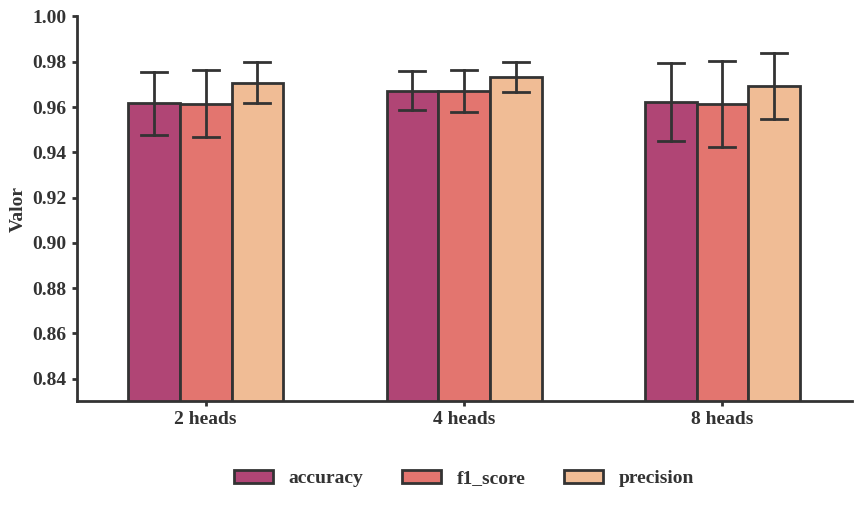

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(data=df_TE_ord, x = 'Cantidad_Cabezas', y = 'Valor', width=0.6,
                 errorbar='sd',capsize=0.1,
                 edgecolor='0.2', lw=2.0,
                 errwidth=2.0,
                 palette= ['#C23373', '#F6635C', '#FFBA86'],
                 errcolor='0.2', hue='Metrica')

#kwargs ={'edgecolor': '0.2', 'linewidth': 2.0, 'fc':'none'}
#ax = sns.swarmplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', marker='o', s=3, **kwargs)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:], labels[:], loc=10, bbox_to_anchor=(0.5, -0.20),
           ncol=3, frameon=False, fontsize=14, labelcolor='0.2',
           prop={'weight':'bold', 'size':14})



for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.0)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xticks(size=14, ha='center', weight='bold', color='0.2')
plt.yticks(size=14, weight='bold', color='0.2')

ax.tick_params(width=2.0, color='0.2')

plt.xlabel('')
plt.ylabel('Valor',size=14, weight='bold', color='0.2')
#plt.ylim(top=1.0)
plt.ylim(0.83, 1.0)

#plt.savefig('bar_accurcys_self.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())
plt.show()

## Entrenamiento del mejor modelo

In [ ]:
# logger
logger_csv_te = CSVLogger('logs', name="modelo_transformer_enc")

# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

checkpoint = ModelCheckpoint(
    dirpath='modelos/transformer_encoder',
    filename='modelo_transformeren_v0_{val_acc:.5f}',
    save_top_k=1,
    monitor='val_acc',
    mode='max'
)

In [ ]:
model_te = ModelTransfomerEncoder(n_heads=8, n_layers=2) # (n_heads=8, n_layers=2)

trainer = pl.Trainer(
                    max_epochs=20,
                    accelerator="auto",
                    logger=logger_csv_te,
                    callbacks=[early_stop_callback, checkpoint], #early_stop_callback
                    log_every_n_steps=len(pal_dm.train_dataloader())
                    )
trainer.fit(model_te, pal_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Tamaño de X_train: 4640
Tamaño de y_train: 4640
Tamaño de X_test: 1160
Tamaño de y_test: 1160


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type       | Params
--------------------------------------------
0 | inp_emb      | Linear     | 19.2 K
1 | tranformer   | Sequential | 1.5 M 
2 | fc           | Linear     | 240 K 
  | other params | n/a        | 4.1 K 
--------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.186     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 00020: reducing learning rate of group 0 to 1.0000e-06.


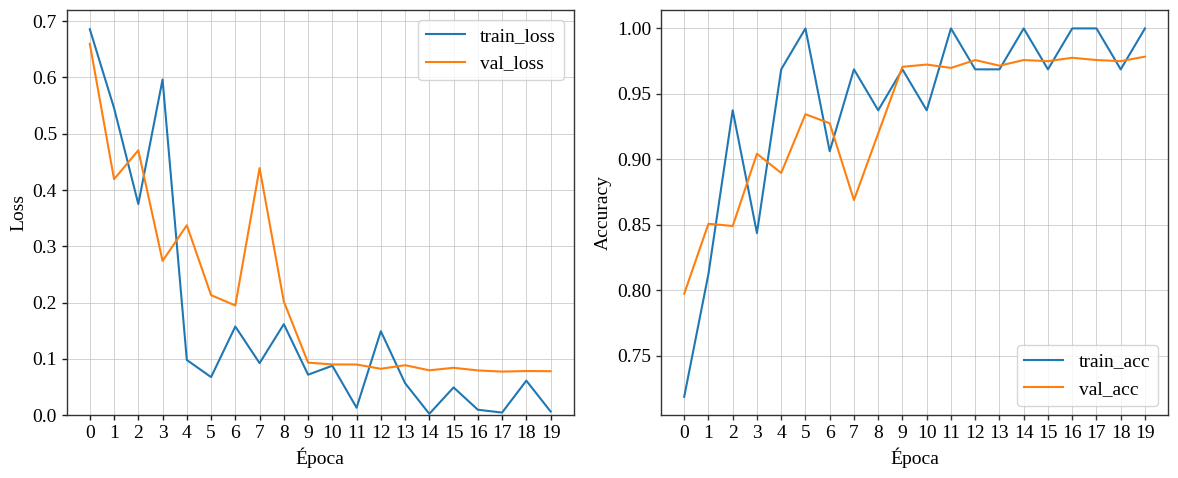

In [ ]:
df = pd.read_csv('logs/modelo_transformer_enc/version_0/metrics.csv')
plot_logs(df, 'Entrenamiento_modelo_Transformer_Encoder')

In [ ]:
df = pd.read_csv('logs/modelo_transformer_enc/version_2/metrics.csv')
plot_logs(df)

In [ ]:
model_te

In [ ]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.


In [ ]:
# model_graph_3 = draw_graph(model_te,
#                            input_size=(32, 30,138),
#                            expand_nested=True,
#                            depth=2,
#                            roll=True,
#                            save_graph=True,
#                            filename='Modelo_Transformer'
#                          )
# model_graph_3.visual_graph

In [ ]:
model_te = ModelTransfomerEncoder.load_from_checkpoint(checkpoint_path="modelo_lsb_te_v5_val_acc=0.91327.ckpt")

## Evaluación

In [ ]:
# Mejor modelo transformer carga y guardado
model_te = ModelTransfomerEncoder.load_from_checkpoint(checkpoint_path="/content/modelos/transformer_encoder/modelo_transformeren_v0_val_acc=0.97845.ckpt")
model_te = model_te.to('cpu')

#torch.save(model_te, 'modelo_transformer_enc3.pt')
model_te.eval()

In [ ]:
# Carga del modelo completo, incluyendo la arquitectura y los pesos
modelo_tranfenco = torch.load('modelo_transformer_enc2.pt')

# Cambia del modelo a modo de evaluación
modelo_tranfenco.eval()

ModelTransfomerEncoder(
  (inp_emb): Linear(in_features=138, out_features=138, bias=True)
  (tranformer): Sequential(
    (0): TransformerEncoderBlock(
      (ln1): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention(
        (key): Linear(in_features=138, out_features=1104, bias=True)
        (query): Linear(in_features=138, out_features=1104, bias=True)
        (value): Linear(in_features=138, out_features=1104, bias=True)
        (proj): Linear(in_features=1104, out_features=138, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=138, out_features=552, bias=True)
        (1): ReLU()
        (2): Linear(in_features=552, out_features=138, bias=True)
      )
    )
    (1): TransformerEncoderBlock(
      (ln1): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((138,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadAttention

In [ ]:
cm_te, lb_real_te, lb_pred_te = cm_predicciones_modelo(model_te, pal_dm)

Tamaño conjunto de validación - real: (1160,)
Tamaño conjunto de validación - predicho: (1160,)


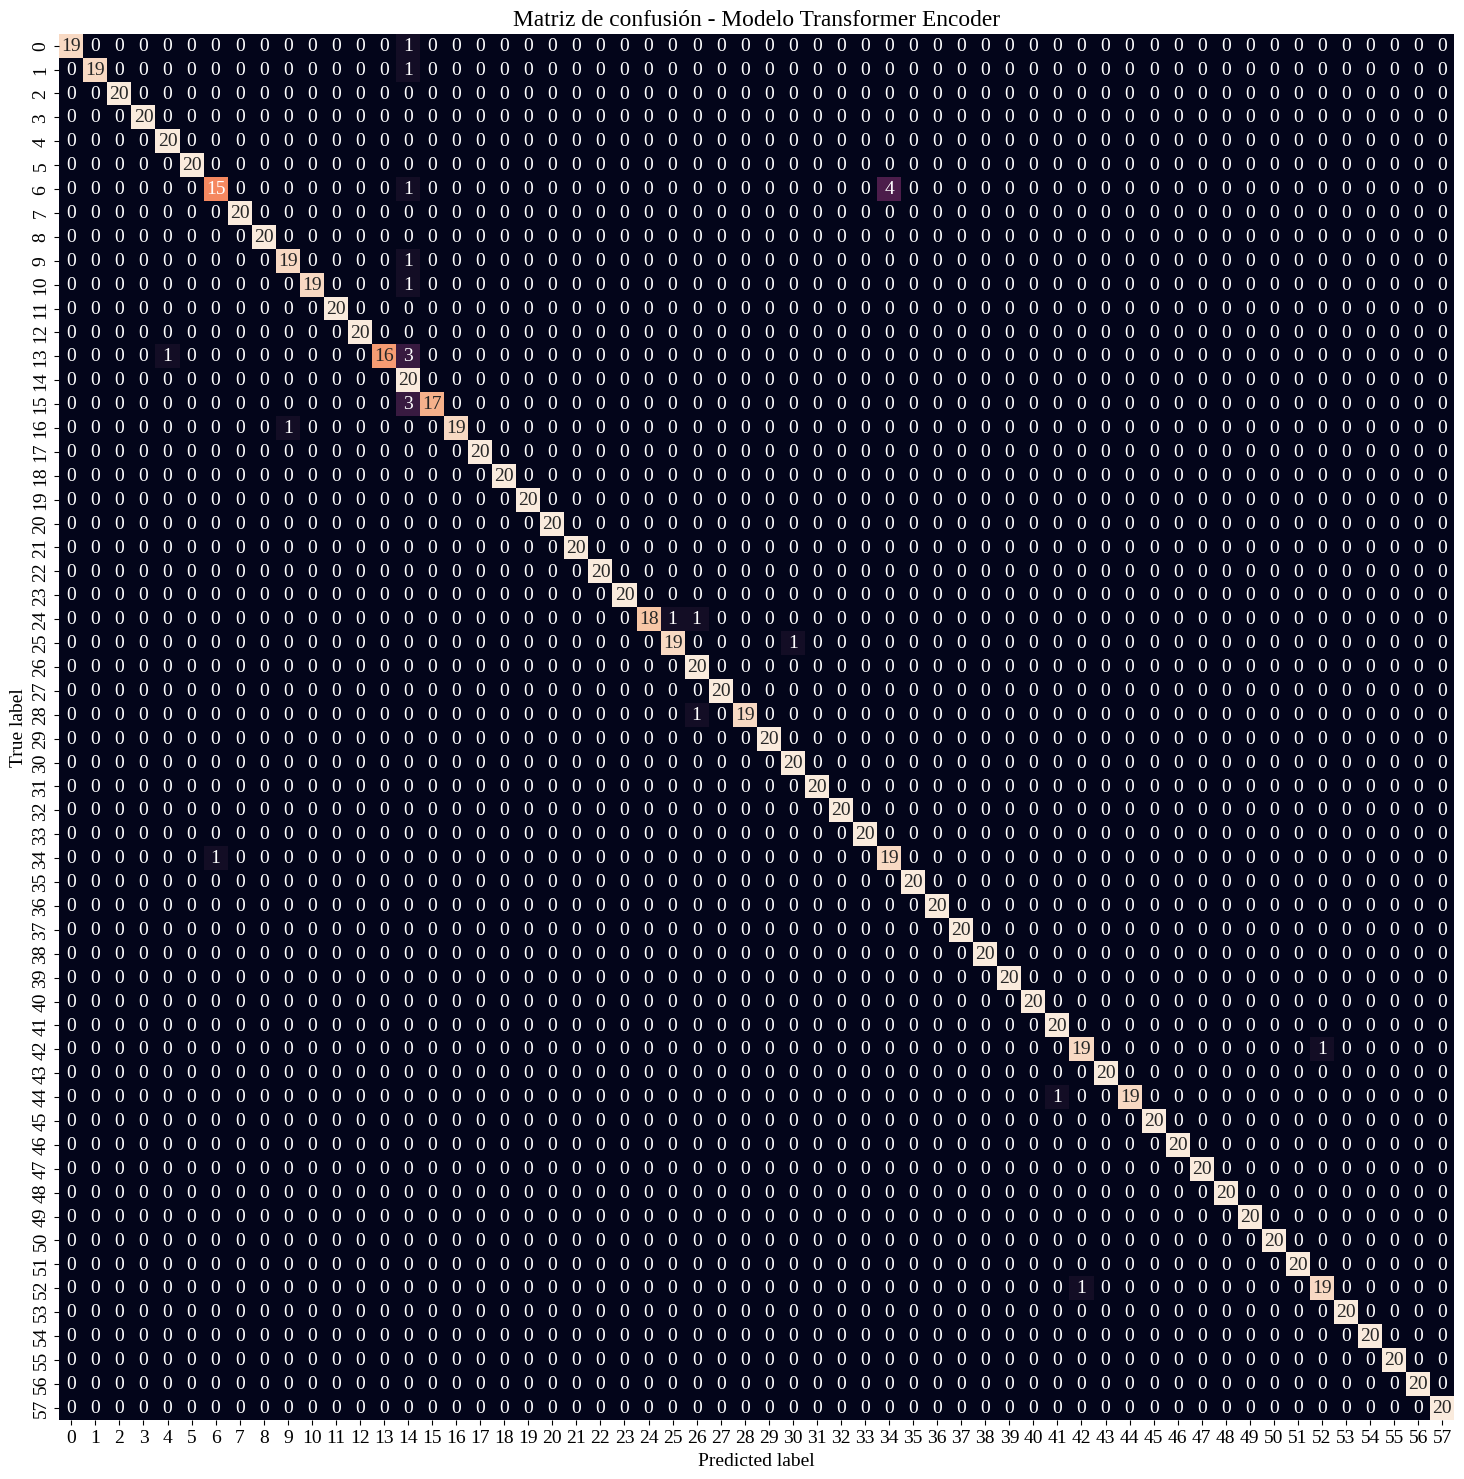

In [ ]:
graficar_matrix_confusion(cm_te, 'Modelo Transformer Encoder', 'Matriz_confusion_Transfromer_Encoder')

La carpeta 'graficos/Transfomer_Encoder/' ha sido creada.


<Figure size 1600x1600 with 0 Axes>

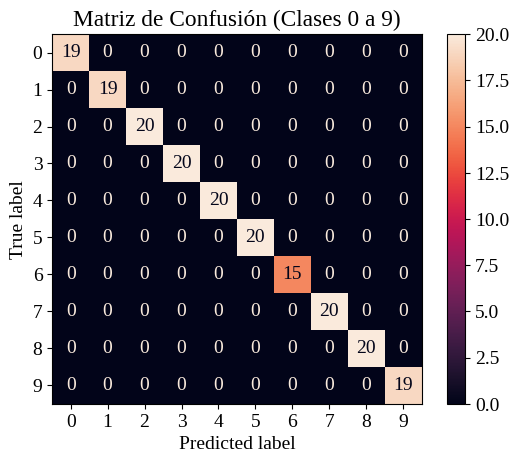

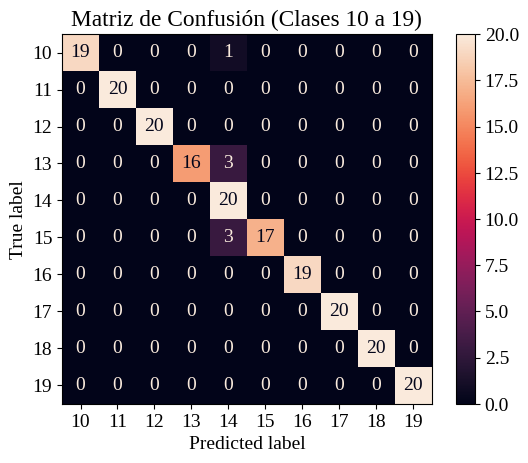

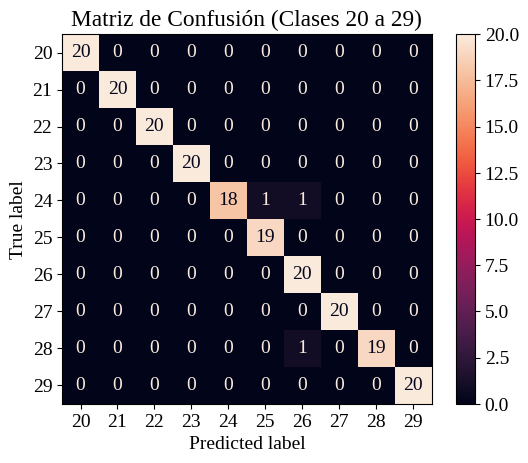

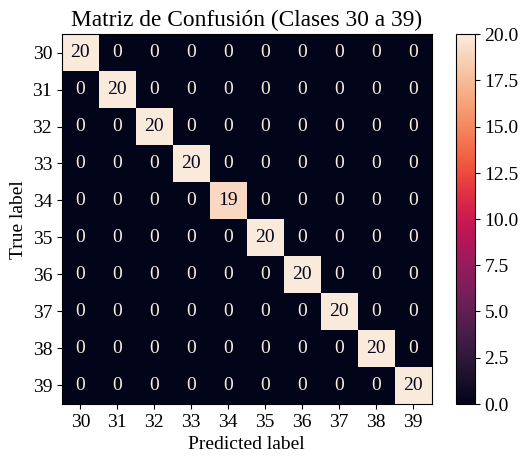

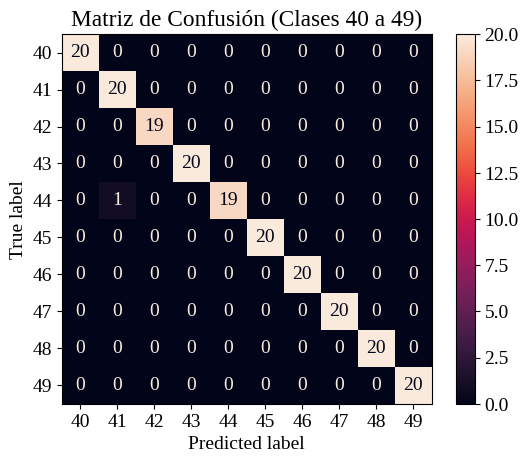

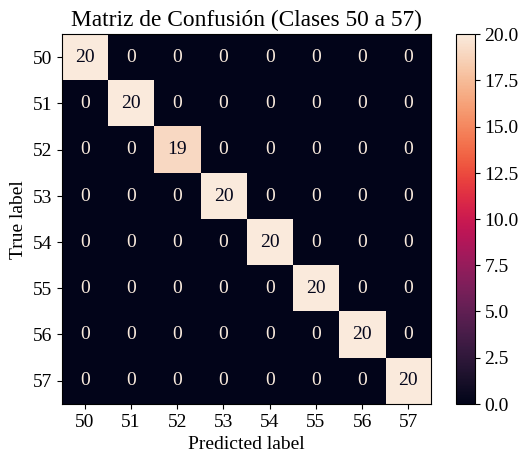

In [ ]:
graficar_matrizConfporpartes(cm_te, lb_real_te, 'Transfomer_Encoder')

In [ ]:
# Guardar imagenes
import shutil
shutil.make_archive('matrices_confusion_Transformer_Encoder', 'zip', '/content/graficos/Transfomer_Encoder')

'/content/matrices_confusion_Transformer_Encoder.zip'

In [ ]:
evaluar_metricas_modelo(lb_real_te, lb_pred_te, 'Modelo Transformer Encoder')

Metricas de evaluación: Modelo Transformer Encoder

Val - Accuracy: 0.978
Val - F1 Score: 0.979
Val - Precisión: 0.982


(0.978448275862069, 0.9789984187024829, 0.9823272760875532)

## Visualizacion rendimiento promedio

In [ ]:
# import os
# # Directorio que contiene los checkpoints
# checkpoint_directory = "modelos/transformer_encoder"

# modelos_transformer = []

# for filename in os.listdir(checkpoint_directory):
#     if filename.endswith(".ckpt"):
#         checkpoint_path = os.path.join(checkpoint_directory, filename)
#         # Carga el modelo desde el checkpoint
#         model = ModelTransfomerEncoder.load_from_checkpoint(checkpoint_path=checkpoint_path)
#         model = model.to('cpu')

#         modelos_transformer.append(model)

In [ ]:
# accuracy_list = []
# f1_list = []
# precision_list = []

# for model in modelos_transformer:
#     model.eval()
#     cm, lb_real, lb_pred = cm_predicciones_modelo(model)
#     accuracy, f1, precision = evaluar_metricas_modelo(lb_real, lb_pred)
#     accuracy_list.append(accuracy)
#     f1_list.append(f1)
#     precision_list.append(precision)

# df_resultados = pd.DataFrame({'accuracy': accuracy_list,
#                               'f1_score': f1_list,
#                               'precision': precision_list})
# df_resultados

In [ ]:
df_resultados.to_csv('resultados_5_entrenamientos_transformers.csv', index=False)

In [ ]:
df_resultados_folds_TE_2h_2encoder

In [ ]:
df_resultados_modelos = pd.melt(df_resultados_folds_TE_8h_2encoder, var_name='Metrica', value_name='Valor')

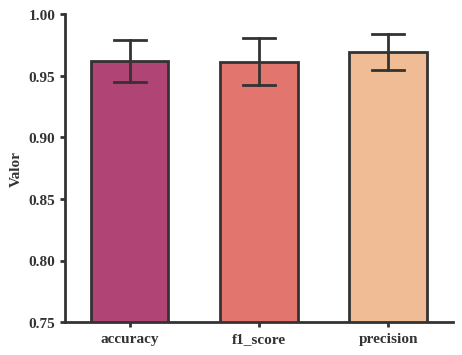

In [ ]:
plt.figure(figsize = (5,4))

ax = sns.barplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', width=0.6,
                 errorbar='sd',capsize=0.25,
                 edgecolor='0.2', lw=2.0,
                 errwidth=2.0,
                 palette=['#C23373', '#F6635C', '#FFBA86'], errcolor='0.2')

#kwargs ={'edgecolor': '0.2', 'linewidth': 2.0, 'fc':'none'}
#ax = sns.swarmplot(data=df_resultados_modelos,x = 'Metrica', y = 'Valor', marker='o', s=3, **kwargs)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(2.0)
    ax.spines[axis].set_color('0.2')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.xticks(size=11, ha='center', weight='bold', color='0.2')
plt.yticks(size=11, weight='bold', color='0.2')

ax.tick_params(width=2.0, color='0.2')

plt.xlabel('')
plt.ylabel('Valor',size=11, weight='bold', color='0.2')
#plt.ylim(top=1.0)
plt.ylim(0.75, 1.0)

plt.savefig('bar_accurcys_self.png', bbox_inches='tight', dpi=250, facecolor=ax.get_facecolor())

## otros


In [ ]:
import torch
import torch.nn as nn

In [ ]:
!pip install torchmetrics --upgrade


In [ ]:
class TransformerEncoderBlok(nn.Module):
    def __init__(self, n_layers_encoder=4, input_size=138, hidden_size=512, n_classes=58):
        super(TransformerEncoderBlok, self).__init__()

        self.embedding = nn.Linear(input_size, hidden_size)
        self.transformer_encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=8) # 8 cabezas
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layers, num_layers=n_layers_encoder)
        self.fc = nn.Linear(hidden_size, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Change the sequence length dimension to the first position
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # Aggregate over the sequence dimension
        x = self.fc(x)
        return x

import torchmetrics

class ModelTranfEncoder(pl.LightningModule):
    def __init__(self, n_layers_encoder=4):
        super(ModelTranfEncoder, self).__init__()
        self.model = TransformerEncoderBlok(n_layers_encoder=n_layers_encoder)
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=58)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # Calcular la exactitud y registrarla
        acc = self.accuracy(outputs.argmax(dim=1), labels)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        # Calcular la exactitud y registrarla
        acc = self.accuracy(outputs.argmax(dim=1), labels)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer


In [ ]:
# logger
logger_csv_te = CSVLogger('logs', name="modelo_transformer_pytorch")

# Callbacks
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   patience=5,
   verbose=False,
   mode='max'
)

checkpoint = ModelCheckpoint(
    dirpath='modelos/transformer_encoder_pytorch',
    filename='modelo_transformeren_pytorch_v3_{val_acc:.5f}',
    save_top_k=1,
    monitor='val_acc',
    mode='max'
)

In [ ]:
model_te_2 = ModelTranfEncoder(n_layers_encoder=2)

trainer = pl.Trainer(
                    max_epochs=20,
                    accelerator="auto",
                    logger=logger_csv_te,
                    callbacks=[early_stop_callback, checkpoint],
                    log_every_n_steps=len(pal_dm.train_dataloader())
                    )
trainer.fit(model_te_2, pal_dm)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/modelos/transformer_encoder_pytorch exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.

Tamaño de X_train: 3447
Tamaño de y_train: 3447
Tamaño de X_test: 383
Tamaño de y_test: 383


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

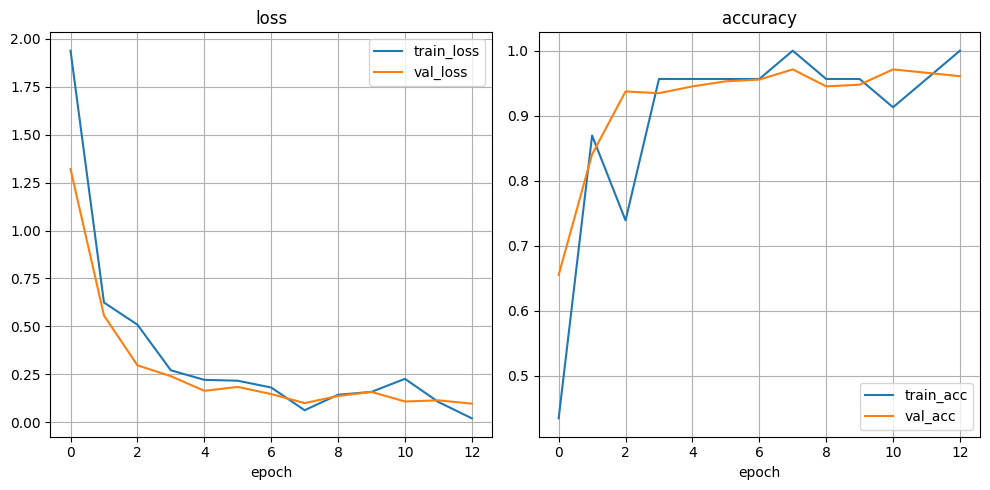

In [ ]:
plot_logs(pd.read_csv('logs/modelo_transformer_pytorch/version_3/metrics.csv'))

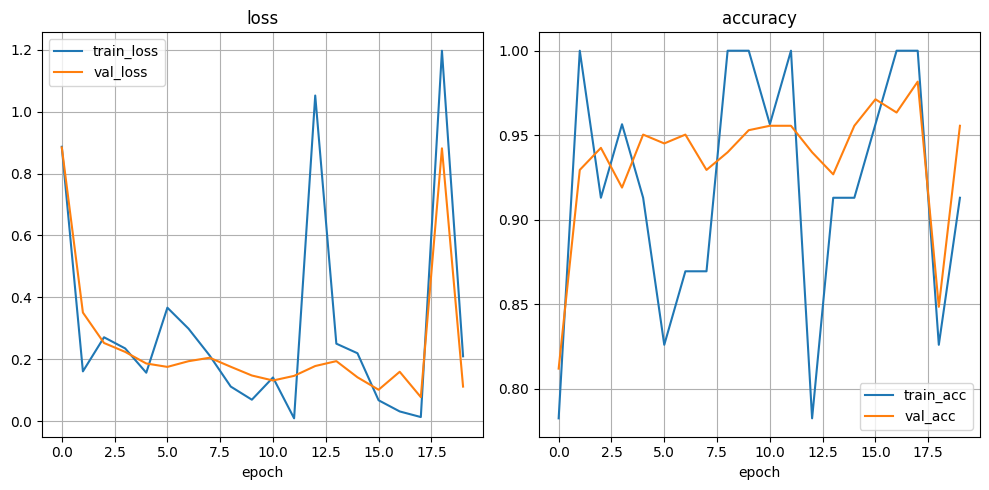

In [ ]:
df = pd.read_csv('logs/modelo_transformer_pytorch/version_0/metrics.csv')
plot_logs(df)

In [ ]:
#cm_te2, lb_real_te2, lb_pred_te2 = cm_predicciones_modelo(model_te_2)

In [ ]:
# model_graph_4 = draw_graph(model_te,
#                            input_size=(32, 30,138),
#                            expand_nested=True,
#                            depth=3,
#                            roll=True,
#                            save_graph=True,
#                            filename='Modelo_Transformer_2'
#                          )
# model_graph_4.visual_graph

## varios

In [ ]:
# # Matriz de confusión
# cm = confusion_matrix(labels_real, labels_preds)
# # ConfusionMatrixDisplay

# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_real))

# plt.figure(figsize=(16,16))
# disp.plot(cmap='viridis')
# plt.title('Matriz de Confusión')
# plt.show()

In [ ]:
# # BALANCEO DE CLASES
# # Identificar las posiciones de las etiquetas 23 y 26
# indices_23 = np.where(labels == 23)[0]
# indices_26 = np.where(labels == 26)[0]

# n_muestras_por_clase = 60

# if len(indices_23) > n_muestras_por_clase:
#     indices_23 = np.random.choice(indices_23, n_muestras_por_clase, replace=False)

# if len(indices_26) > n_muestras_por_clase:
#     indices_26 = np.random.choice(indices_26, n_muestras_por_clase, replace=False)

# # Indices de las otras clases
# indices_otros = np.where((labels != 23) & (labels != 26))[0]

# # Unir los nuevos indices reducidos con los indices de otras clases
# nuevos_indices = np.concatenate([indices_23, indices_26, indices_otros])

# # Filtrar los datos originales con los nuevos indices
# datos_balanceados = datos[nuevos_indices]
# labels_balanceados = labels[nuevos_indices]

# # Verificar las dimensiones
# print("Dimensiones de datos_balanceados:", datos_balanceados.shape)
# print("Dimensiones de labels_balanceados:", labels_balanceados.shape)

In [ ]:
# selec solo datos mov para pruebas: palabras con movimiento
# etiqueta_min = 38
# etiqueta_max = 52
# # índice booleano
# indices_rango = (labels >= etiqueta_min) & (labels <= etiqueta_max)
# # Seleccionar los datos y etiquetas que corresponden a las etiquetas en el rango
# datos_selec = datos[indices_rango]
# labels_selec = labels[indices_rango]

# # Puedes verificar las formas de los nuevos arrays resultantes
# print("Forma de datos_selec:", datos_selec.shape)
# print("Forma de labels_selec:", labels_selec.shape)

In [ ]:
# # Mapeo de Clases de palamras con movimiento solo para pruebas

# # Definir un diccionario de mapeo de valores originales a nuevos valores
# mapeo = {38: 0, 39: 1, 40: 2, 41: 3, 42: 4, 43: 5, 44: 6, 45: 7, 46: 8, 47: 9, 48: 10, 49: 11, 50: 12, 51: 13, 52: 14}

# # Aplicar el mapeo para obtener un nuevo vector de valores
# labels_map = np.array([mapeo[x] for x in labels_selec])

# # Ahora, vector_remapped contendrá los valores mapeados
# print(labels_map.shape)


In [ ]:
# def plot_logs(df):
#     df = df.groupby('epoch')[['train_loss', 'train_acc', 'val_loss', 'val_acc']].sum().reset_index()

#     # Configurar el estilo de Seaborn (opcional, pero puede mejorar la apariencia)
#     #sns.set_style("whitegrid")

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

#     # Primer subplot - Loss
#     sns.lineplot(x='epoch', y='value', hue='variable',
#                  data=pd.melt(df, id_vars=['epoch'], value_vars=['train_loss', 'val_loss']),
#                  ax=axes[0], )
#     axes[0].legend_.set_title('')
#     axes[0].set_ylabel('Loss')
#     axes[0].set_xlabel('Época')
#     axes[0].set_ylim(bottom=0)
#     axes[0].set_xticks(df['epoch'].unique())

#     for axis in ['bottom', 'left']:
#         axes[0].spines[axis].set_linewidth(1.0)
#         axes[0].spines[axis].set_color('0.2')

#     axes[0].tick_params(axis='x', width=1.0)
#     axes[0].tick_params(axis='y', width=1.0)

#     # Segundo subplot - Accuracy
#     sns.lineplot(x='epoch', y='value', hue='variable', data=pd.melt(df, id_vars=['epoch'], value_vars=['train_acc', 'val_acc']), ax=axes[1])
#     axes[1].legend_.set_title('')
#     axes[1].set_ylabel('Accuracy')
#     axes[1].set_xlabel('Época')
#     axes[1].set_xticks(df['epoch'].unique())

#     for axis in ['bottom', 'left']:
#         axes[1].spines[axis].set_linewidth(1.0)
#         axes[1].spines[axis].set_color('0.2')
#     axes[1].grid(True, color='silver', linestyle='-', linewidth=0.5)

#     plt.tight_layout()
#     plt.show()

# # Ejemplo de uso
# # plot_logs(tu_dataframe)

In [ ]:
# def plot_logs(df, name_fig=''):
#     df = df.groupby('epoch')[['train_loss', 'train_acc', 'val_loss', 'val_acc']].sum().reset_index()
#     fig = plt.figure(figsize=(10, 5))
#     ax = fig.add_subplot(121)
#     df.plot(x='epoch', y=['train_loss', 'val_loss'], grid=True, title='loss', ax=ax)

#     ax = fig.add_subplot(122)
#     df.plot(x='epoch', y=['train_acc','val_acc'], grid=True, title='accuracy', ax=ax)
#     plt.tight_layout()

#     if name_fig:
#         plt.savefig(f'{name_fig}.png', bbox_inches='tight', dpi=200, facecolor=ax.get_facecolor())
#     plt.show()


In [ ]:
# stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# accuracies = []
# # Itera a través de los pliegues (folds)
# for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(datos_features, labels_lsb)):
#     print(f"Fold {fold + 1}")

#     # Divide los datos en conjuntos de entrenamiento y validación
#     train_data = datos_features[train_idx]
#     train_labels = labels_lsb[train_idx]
#     val_data = datos_features[val_idx]
#     val_labels = labels_lsb[val_idx]

#     # Actualiza el conjunto de datos en el DataModule con los nuevos datos de entrenamiento y validación
#     pal_dm2 = PalabrasDataModule2(
#         PalabrasDataset(train_data, train_labels),
#         PalabrasDataset(val_data, val_labels)
#         )

#     # Inicializa el modelo, el optimizador y el entrenador de PyTorch Lightning
#     model = ModelSelfAttn()
#     trainer = pl.Trainer(max_epochs=5)

#     # Entrenamiento y validación utilizando PyTorch Lightning
#     trainer.fit(model, pal_dm2)

In [ ]:
# import os
# # Directorio que contiene los checkpoints
# checkpoint_directory = "modelos/self_attention/"

# modelos_sa = []

# for filename in os.listdir(checkpoint_directory):
#     if filename.endswith(".ckpt"):
#         checkpoint_path = os.path.join(checkpoint_directory, filename)
#         # Carga el modelo desde el checkpoint
#         model = ModelSelfAttn.load_from_checkpoint(checkpoint_path=checkpoint_path)
#         model = model.to('cpu')

#         modelos_sa.append(model)

In [ ]:
# accuracy_list = []
# f1_list = []
# precision_list = []

# for model in modelos_sa:
#     model.eval()
#     cm, lb_real, lb_pred = cm_predicciones_modelo(model)
#     accuracy, f1, precision = evaluar_metricas_modelo(lb_real, lb_pred)
#     accuracy_list.append(accuracy)
#     f1_list.append(f1)
#     precision_list.append(precision)

# df_resultados = pd.DataFrame({'accuracy': accuracy_list,
#                               'f1_score': f1_list,
#                               'precision': precision_list})
# df_resultados